# Graphs for the journal paper

In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2,fftshift,ifftshift,fftn,ifftn
from pyfftw.interfaces.numpy_fft import fft2 as pfft2
from pyfftw.interfaces.numpy_fft import ifft2 as pifft2

from pyfftw.interfaces.numpy_fft import fftn as pfftn
from pyfftw.interfaces.numpy_fft import ifftn as pifftn

import matplotlib.pyplot as plt
from matplotlib import  rc

import time
import scipy.stats as st
from os.path import exists

# display config
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.origin'] = 'lower'

import scipy.signal as si
from scipy import ndimage as ndi

import gc
import sys
sys.path.insert(0, "../2D/")

############
#import tools as t
import sampling as s
import Gaussian_MRF as gmrf
import gums
#
%load_ext autoreload
%autoreload 2


In [2]:
from mrfx.models._gmrf import GMRF
from mrfx.models._gum import GUM

from mrfx.samplers._spectral import SpectralSamplerGMRF
from mrfx.samplers._fft import FFTSamplerGMRF

import jax
key = jax.random.PRNGKey(1)

In [3]:
def clear_ticks():
    plt.gca().set_xticks(())
    plt.gca().set_yticks(())
    plt.tight_layout()

In [4]:
def plot_2D_DGUM(Z):
    X = gums.phi(Z)
    
    vertices = gums.get_vertices(K)
    
    pcmc = X[:,:].flatten()
    px = Z[0,:,:].flatten()
    py = Z[1,:,:].flatten()
    cmap = plt.colormaps['cividis']
    
    # Take colors at regular intervals spanning the colormap.
    colorslist = cmap(np.linspace(0, 1, 3))
    
    fig=plt.figure(figsize=(3.5,3.5))
    colors=colorslist[0], colorslist[1],colorslist[2]#'orange','darkblue','purple'
    
    for k in range(K):
        mask = pcmc==k
        plt.plot(px[mask],py[mask],'.',markeredgecolor=colors[k],alpha=0.1,ms=1.5,c=colors[k])
        plt.plot(-5,-5,'.',c=colors[k],alpha=1,ms=4,label=f"$\\omega_{k}$")
    
    pmin, pmax = -3,3
    plt.ylim(pmin,pmax); plt.xlim(pmin,pmax)#,2);plt.xlim(-2,2)
    
    plt.xlabel("$\\mathbf{z}_0$")
    plt.ylabel("$\\mathbf{z}_1$")
    plt.grid()
    plt.plot(vertices[:,0],vertices[:,1],'*',ms=16,c='w',
             markeredgecolor='k',label = '$\\mathbf{v}_k$')#Unitary simplex vertices')
    plt.legend(loc='upper left')
    plt.tight_layout()

def plot_kde_prob_simplex(kde_sampling):
        plt.figure(figsize=(4,4))
        corners = ((-0.5, 0.0), (0.5, 0), (0, 1))
        extent = [corners[0][0]-1/N, corners[1][0]+1/N,corners[0][1]-1/N,corners[2][1]+1/N]
        ax = plt.subplot(projection="ternary",corners=corners)
        plt.imshow((kde_sampling.T),cmap=plt.cm.Blues,extent=extent
                
                  )
      
        ax.set_tlabel("$\\omega_0$")
        ax.set_llabel("$\\omega_1$")
        ax.set_rlabel("$\\omega_2$")
        plt.tight_layout()

In [5]:
def sample_3Z(kappa,method='spectral'):
    n_bands = 2000
    P,Q = 200,200
    K=3
    N=K-1
    nu = 3
    
    gmrf = GMRF(kappa=kappa,nu=nu, dim=2)

    if method=='spectral':
        gmrf_sampler = SpectralSamplerGMRF(
                        n_bands=n_bands, lx=P,ly=Q
                    )
    else:
        gmrf_sampler = FFTSamplerGMRF(lx=P, ly=Q)
    #subkeys = jax.random.split(key, K - 1)
    
    Z = np.zeros(shape=(N,P,Q))
    subkeys = jax.random.split(key, K - 1)
    for i in range(N):
        Z[i] = gmrf_sampler.sample_image(gmrf, subkeys[i])
    return Z

def phi3_det(Z,c):
    K = 3
    vertices = gums.get_vertices(K)
    
    vmin = Z.min();vmax=Z.max()
    Znorm = Z / np.linalg.norm(Z,axis=0)[np.newaxis,:,:,]
    Z0 = Z- (vertices[0])[:,np.newaxis,np.newaxis]
    norm0 = np.exp(  -(np.linalg.norm(Z0,axis=0)**2)/c**2)
    Z1 = Z- (vertices[1])[:,np.newaxis,np.newaxis]
    norm1 = np.exp( - (np.linalg.norm(Z1,axis=0)**2)/c**2)
    Z2 = Z- (vertices[2])[:,np.newaxis,np.newaxis]
    norm2 = np.exp( - (np.linalg.norm(Z2,axis=0)**2)/c**2)
    #Pi = 1-sigmo(5*norm0)

    total = norm0+norm1+norm2
    p1 = norm1/total
    p0 = norm0/total
    p2 = norm2/total

    compo = 0 * p0 + 1 * p1 + 2 * p2
    
    return compo,p0,p1,p2


In [6]:
folder = "/home/jean-baptiste/Resultats/GUMs/figures/"

# Figure 1 : intuition 

In [28]:
# homemade code
import MRF2 as mrf # ! only 2-class MRF so far

P,Q = 200,200

Theta_MRF = mrf.Param_MRF()
Theta_MRF.P = P
Theta_MRF.Q = Q

np.random.seed(1)
X_mrf = mrf.Gibbs_chroma(Theta_MRF)

In [29]:
n_bands = 2000
K=2
kappa = 0.3
nu = 3

gmrf = GMRF(kappa=kappa,nu=nu, dim=2)   
gmrf_sampler = SpectralSamplerGMRF(n_bands=n_bands, lx=P,ly=Q)

Z = gmrf_sampler.sample_image(gmrf, key)


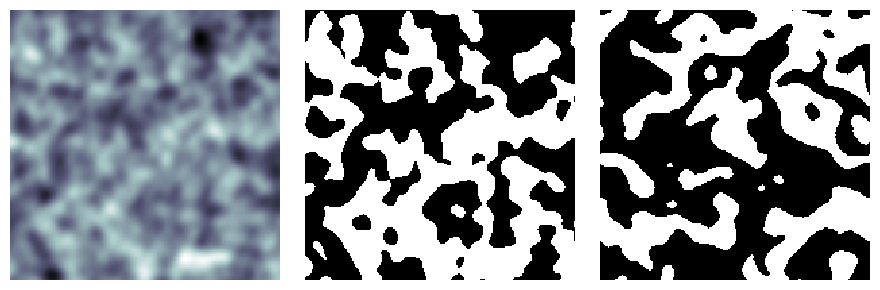

In [30]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(Z,cmap=plt.cm.bone_r);plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(Z>0,cmap=plt.cm.bone_r);plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(X_mrf,cmap=plt.cm.bone_r);plt.axis('off')

plt.tight_layout()

In [31]:
plt.imsave('/home/jean-baptiste/Resultats/GUMs/figures/fig1_x_mrf.png',X_mrf*1.0,cmap=plt.cm.gray)
plt.imsave('/home/jean-baptiste/Resultats/GUMs/figures/fig1_z_thr.png',Z>0,cmap=plt.cm.gray)
plt.imsave('/home/jean-baptiste/Resultats/GUMs/figures/fig1_z.png',Z,cmap=plt.cm.bone_r)


# Figure 2 : representations of $\pi_k$

In [7]:

K=3

Z = sample_3Z(kappa=0.2)


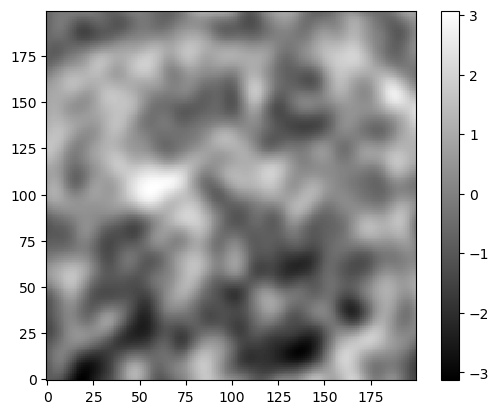

In [48]:
plt.imshow(Z[1]);plt.colorbar()

## (a) and (b) plotting the fields

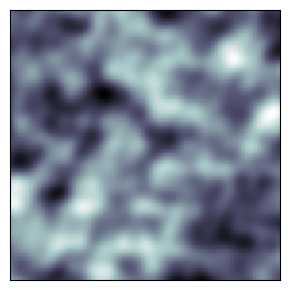

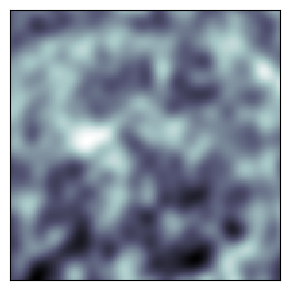

In [38]:
#plt.imsave(folder+"fig2_z1.png",Z[0],cmap=plt.cm.bone)
#plt.imsave(folder+"fig2_z2.png",Z[1],cmap=plt.cm.bone)

plt.figure(figsize=(3,3));plt.imshow(Z[0],cmap=plt.cm.bone)
clear_ticks()
plt.savefig(folder+'fig2_z1.pdf')

plt.figure(figsize=(3,3));plt.imshow(Z[1],cmap=plt.cm.bone)
clear_ticks()
plt.savefig(folder+'fig2_z2.pdf')

## (c) Representation of marginals 

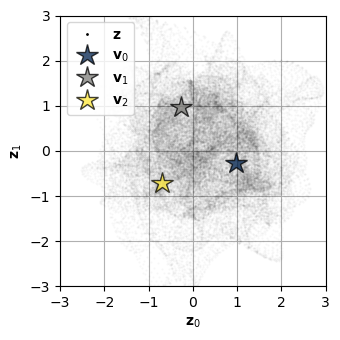

In [8]:
K = 3
vertices = gums.get_vertices(K)
    
P,Q = 200,200
lim = P
px = Z[0,:lim,:].flatten()
py = Z[1,:lim,:].flatten()
#pcmc = X[:lim,:].flatten()

pmin = min(px.min(),py.min())
pmax=max(px.max(),py.max())
pmax = max(-pmin,pmax) ; pmin = min(-pmax,pmin)
pmin, pmax = -3,3

plt.figure(figsize=(3.5,3.5))
plt.plot(px,py,'.',c='k',alpha=0.03,ms=1.)#,label='$\\mathbf{z}$')
plt.plot(-10,-10,'.',c='k',alpha=1,ms=2,label='$\\mathbf{z}$')

plt.ylim(pmin,pmax); plt.xlim(pmin,pmax)#,2);plt.xlim(-2,2)
plt.xlabel("$\\mathbf{z}_0$")
plt.ylabel("$\\mathbf{z}_1$")
plt.grid()

cmap = plt.colormaps['cividis']
# Take colors at regular intervals spanning the colormap.
colorslist = cmap(np.linspace(0, 1, 3))
colors=colorslist[0], colorslist[1],colorslist[2]#'orange','darkblue','purple'

for k in range(3):
    plt.plot(vertices[k,0],vertices[k,1],'*',ms=16,c=colors[k],
         markeredgecolor='k',label = '$\\mathbf{v}_'+str(k)+'$',alpha=0.75)#Unitary simplex vertices')
plt.legend()
plt.tight_layout()
plt.savefig(folder+"fig2_z2d.pdf")#,dpi=200)
plt.savefig(folder+"fig2_z2d.png",dpi=200)
#plt.savefig("/home/courbot/Documents/HDR/Presentation/figures/z.png",dpi=200)



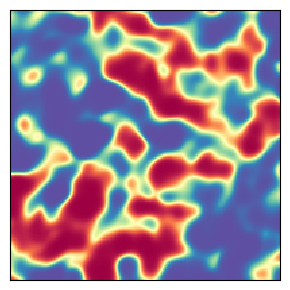

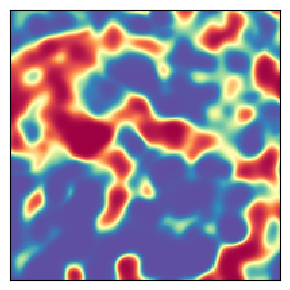

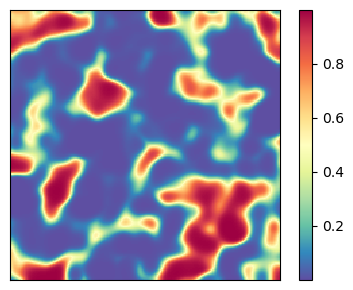

In [40]:
compo,p0,p1,p2 = phi3_det(Z,c=1)

#plt.imsave(folder+"fig2_pi1.png",p0,cmap=plt.cm.Spectral_r)



plt.figure(figsize=(3,3));plt.imshow(p0,cmap=plt.cm.Spectral_r)
clear_ticks()
plt.savefig(folder+'fig2_pi0.pdf')
plt.figure(figsize=(3,3));plt.imshow(p1,cmap=plt.cm.Spectral_r)
clear_ticks()
plt.savefig(folder+'fig2_pi1.pdf')
plt.figure(figsize=(4,3))
plt.imshow(p2,cmap=plt.cm.Spectral_r)
plt.colorbar()
clear_ticks()
plt.savefig(folder+'fig2_pi2.pdf')
#plt.tight_layout()

# Figure 3: probability simplex, to place here

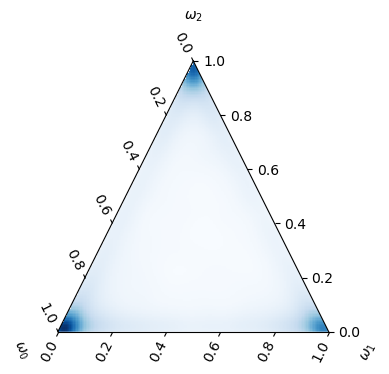

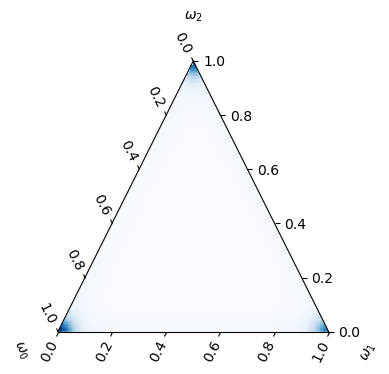

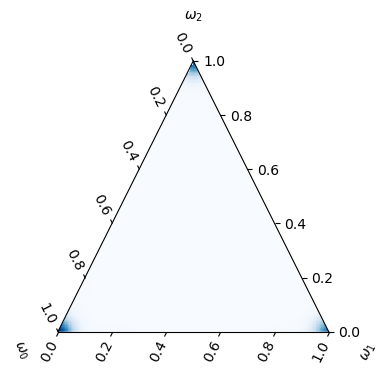

In [75]:
def calc_KDE_prob_simplex(a,b,c,N):

    px = 0.5*(b-a)
    py = c
    arr = np.array([px,py])
    
    bw = 0.05
    dx = np.linspace(-0.5,0.5,N).reshape(1,N,1)#reshape(-1,1)
    dy = np.linspace(0,1,N).reshape(1,1,N)#reshape(-1,1)
    
    dist = np.sqrt( (dx-px.reshape(px.size,1,1))**2 + (dy-py.reshape(px.size,1,1))**2)
    # une gaussienne 
    gau = np.exp(-dist**2 * 1/bw**2)

    kde = gau.sum(axis=0)

    mask = (2*dx+1 >= 4*dy)[0]
    mask2=mask[:,::-1]
    
    kde[mask.T+mask2.T] *= 0 
    Npt = (mask.T+mask2.T).sum()
    kde /= kde.sum()
    kde /= Npt
    #kde *= (mask.T+mask2.T).sum()
    kde[mask.T+mask2.T] +=  np.nan

    return kde

N = 200
moy = np.zeros(shape=(N,N))
import mpltern

Z = sample_3Z(kappa=0.4)

for c in (1,0.5,0.25):
    compo,p0,p1,p2 = phi3_det(Z,c=c)
    kde_sampling = calc_KDE_prob_simplex(p0,p1,p2,N=N)

    plot_kde_sampling(kde_sampling)
    #plt.colorbar()
    #ax.grid()
    plt.tight_layout()
    plt.savefig('/home/jean-baptiste/Resultats/GUMs/figures/prob_simplex_c_'+str(c)+'.pdf')
    plt.show()

# Figure 4 : (a-c) mapping of $\phi$

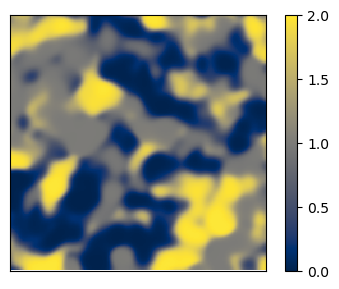

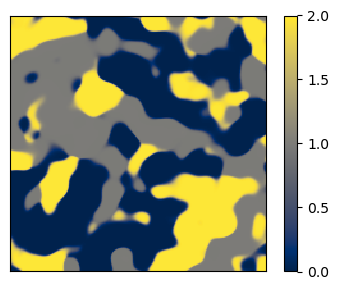

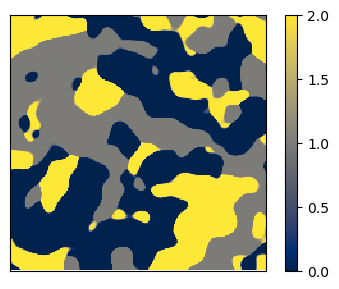

In [30]:
Z = sample_3Z(kappa=0.2)
compo,p0,p1,p2 = phi3_det(Z,c=1)

plt.figure(figsize=(4,3));
plt.imshow(compo,cmap=plt.cm.cividis,vmin=0,vmax=2);
plt.colorbar(ticks=np.linspace(0, 2, 5))
clear_ticks()
plt.savefig(folder+'fig4_a.pdf')

compo,p0,p1,p2 = phi3_det(Z,c=0.5)
plt.figure(figsize=(4,3));
plt.imshow(compo,cmap=plt.cm.cividis);
plt.colorbar(ticks=np.linspace(0, 2, 5))
clear_ticks()
plt.savefig(folder+'fig4_b.pdf')

compo,p0,p1,p2 = phi3_det(Z,c=0.25)
plt.figure(figsize=(4,3));
plt.imshow(compo,cmap=plt.cm.cividis);
plt.colorbar(ticks=np.linspace(0, 2, 5))
clear_ticks()
plt.savefig(folder+'fig4_c.pdf')
#plt.colorbar()


## (d) DGUM

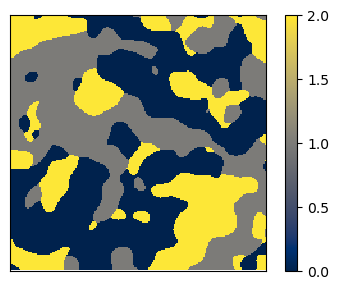

In [31]:
X = gums.phi(Z)
plt.figure(figsize=(4,3));
plt.imshow(X,cmap=plt.cm.cividis);
plt.colorbar(ticks=np.linspace(0, 2, 5))
clear_ticks()
plt.savefig(folder+'fig4_d.pdf')


## (e) 2D visualization 

In [40]:
Z = sample_3Z(kappa=0.2)

In [43]:
Z.mean()

0.1500919341812426

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_290466/2537676410.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(-5,-5,'.',c=colors[k],alpha=1,ms=4,label=f"$\omega_{k+1}$")


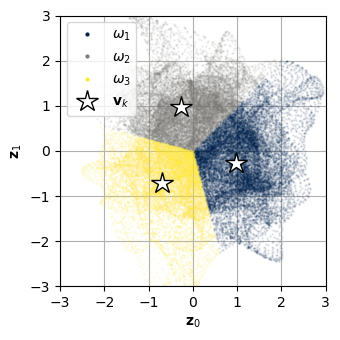

In [9]:
X = gums.phi(Z)

pcmc = X[:,:].flatten()

cmap = plt.colormaps['cividis']

# Take colors at regular intervals spanning the colormap.
colorslist = cmap(np.linspace(0, 1, 3))

fig=plt.figure(figsize=(3.5,3.5))
#draw_center_axis(fig)
colors=colorslist[0], colorslist[1],colorslist[2]#'orange','darkblue','purple'

for k in range(K):
    mask = pcmc==k
    plt.plot(px[mask],py[mask],'.',markeredgecolor=colors[k],alpha=0.1,ms=1.5,c=colors[k])
    plt.plot(-5,-5,'.',c=colors[k],alpha=1,ms=4,label=f"$\omega_{k+1}$")

pmin, pmax = -3,3
plt.ylim(pmin,pmax); plt.xlim(pmin,pmax)#,2);plt.xlim(-2,2)


plt.xlabel("$\\mathbf{z}_0$")
plt.ylabel("$\\mathbf{z}_1$")
plt.grid()
plt.plot(vertices[:,0],vertices[:,1],'*',ms=16,c='w',
         markeredgecolor='k',label = '$\\mathbf{v}_k$')#Unitary simplex vertices')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(folder+"fig4_e_dgum_2d.png",dpi=200)


# Figure 5 : unbalanced and anisotropic GUMs

## (a - e) Unbalanced

In [21]:
Z += vertices[2][:,np.newaxis,np.newaxis]

In [129]:
vertices[2]

array([-0.1545085 , -0.1545085 ,  0.96352549, -0.1545085 ])

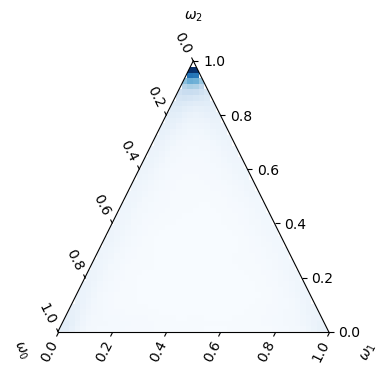

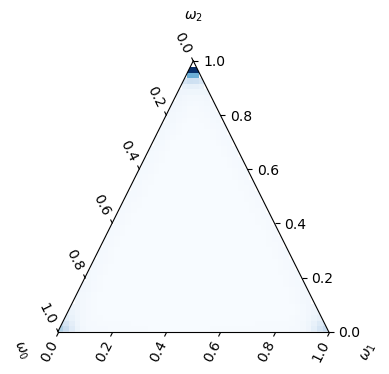

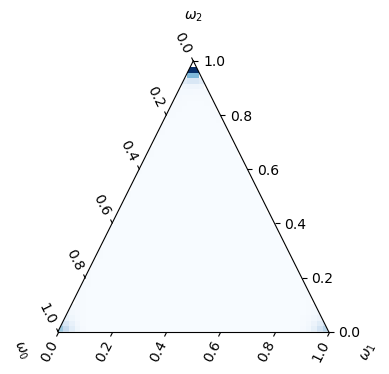

In [132]:

N = 200
moy = np.zeros(shape=(N,N))
import mpltern

corners = ((-0.5, 0.0), (0.5, 0), (0, 1))
extent = [corners[0][0]-1/N, corners[1][0]+1/N,corners[0][1]-1/N,corners[2][1]+1/N]

key = jax.random.PRNGKey(1)
Z = sample_3Z(kappa=0.4)
K=3
vertices = gums.get_vertices(K)
Z += vertices[2][:,np.newaxis,np.newaxis]

for c in (1,0.5,0.25):
    compo,p0,p1,p2 = phi3_det(Z,c=c)
    kde_sampling = calc_KDE_prob_simplex(p0,p1,p2,N=N)

    plt.figure(figsize=(4,4))
    ax = plt.subplot(projection="ternary",corners=corners)
    plt.imshow((kde_sampling.T),cmap=plt.cm.Blues,extent=extent
               #np.log10(kde_sampling.max()),vmin=np.log10(kde_sampling.max()/10)
              )
  
    ax.set_tlabel("$\\omega_0$")
    ax.set_llabel("$\\omega_1$")
    ax.set_rlabel("$\\omega_2$")
    #plt.colorbar()
    #ax.grid()
    plt.tight_layout()
    plt.savefig('/home/jean-baptiste/Resultats/GUMs/figures/prob_simplex_unbalanced_c_'+str(c)+'.pdf')
    plt.show()

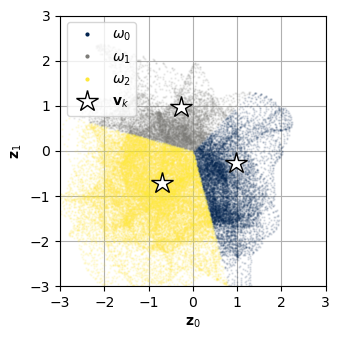

In [39]:
key = jax.random.PRNGKey(1)
Z = sample_3Z(kappa=0.2)
vertices = gums.get_vertices(K)
Z += vertices[2][:,np.newaxis,np.newaxis]

X = gums.phi(Z)

pcmc = X[:,:].flatten()
px = Z[0,:,:].flatten()
py = Z[1,:,:].flatten()
cmap = plt.colormaps['cividis']

# Take colors at regular intervals spanning the colormap.
colorslist = cmap(np.linspace(0, 1, 3))

fig=plt.figure(figsize=(3.5,3.5))
colors=colorslist[0], colorslist[1],colorslist[2]#'orange','darkblue','purple'

for k in range(K):
    mask = pcmc==k
    plt.plot(px[mask],py[mask],'.',markeredgecolor=colors[k],alpha=0.1,ms=1.5,c=colors[k])
    plt.plot(-5,-5,'.',c=colors[k],alpha=1,ms=4,label=f"$\\omega_{k}$")

pmin, pmax = -3,3
plt.ylim(pmin,pmax); plt.xlim(pmin,pmax)#,2);plt.xlim(-2,2)


plt.xlabel("$\\mathbf{z}_0$")
plt.ylabel("$\\mathbf{z}_1$")
plt.grid()
plt.plot(vertices[:,0],vertices[:,1],'*',ms=16,c='w',
         markeredgecolor='k',label = '$\\mathbf{v}_k$')#Unitary simplex vertices')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(folder+"fig5_unbalanced_dgum_2d.png",dpi=200)


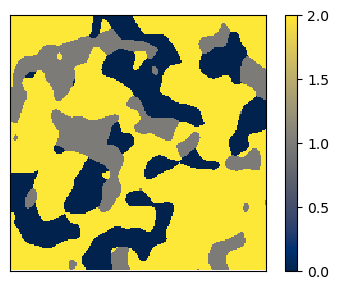

In [139]:
X = gums.phi(Z)
plt.figure(figsize=(4,3));
plt.imshow(X,cmap=plt.cm.cividis);
plt.colorbar(ticks=np.linspace(0, 2, 5))
clear_ticks()
plt.savefig(folder+'fig5_x.pdf')

## (f-g) anisotropic

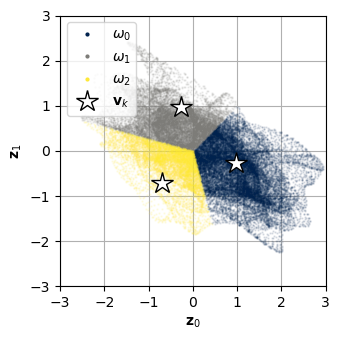

In [26]:
key = jax.random.PRNGKey(1)
Z = sample_3Z(kappa=0.2)

Z[1] = 0.6*Z[1] - 0.4*Z[0]# vertices[2][:,np.newaxis,np.newaxis]

plot_2D_DGUM(Z)
plt.savefig(folder+"fig5_anisotropic_dgum_2d.png",dpi=200)


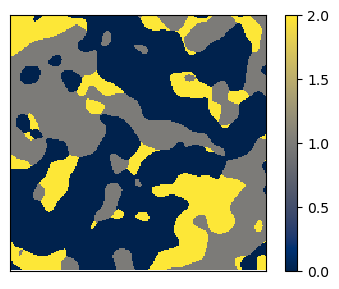

In [150]:
X = gums.phi(Z)
plt.figure(figsize=(4,3));
plt.imshow(X,cmap=plt.cm.cividis);
plt.colorbar(ticks=np.linspace(0, 2, 5))
clear_ticks()
plt.savefig(folder+'fig5_x_ani.pdf')

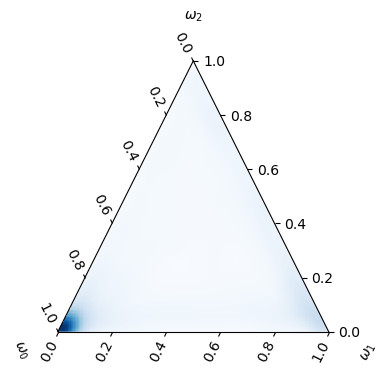

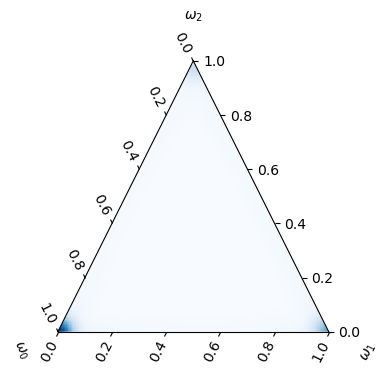

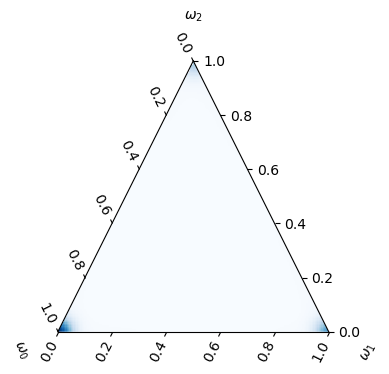

In [151]:

N = 200
moy = np.zeros(shape=(N,N))
import mpltern



key = jax.random.PRNGKey(1)
Z = sample_3Z(kappa=0.2)

Z[1] = 0.6*Z[1] - 0.4*Z[0]# vertices[2][:,np.newaxis,np.newaxis]

for c in (1,0.5,0.25):
    compo,p0,p1,p2 = phi3_det(Z,c=c)
    kde_sampling = calc_KDE_prob_simplex(p0,p1,p2,N=N)
    plot_kde_sampling(kde_sampling)
    
    plt.savefig('/home/jean-baptiste/Resultats/GUMs/figures/prob_simplex_anisotropic_c_'+str(c)+'.pdf')
    plt.show()

# Figure 6 / 10 : time results

array([2.560000e+02, 1.024000e+03, 4.096000e+03, 1.638400e+04,
       6.553600e+04, 2.621440e+05, 1.048576e+06, 4.194304e+06])

In [55]:
import pandas as pd

N = 6

ymin = 0.0005#res.min()
ymax=170#res.max()
labels = np.arange(2,8)

Ns = 8
Nk = 6
all_res = np.zeros(shape=(6,Ns,Nk))+np.nan

df_FC = pd.read_csv('./measures/old/GUMSampler_fourier_CPU_time.csv')
df_FCx = pd.read_csv('./measures/GUMSampler_fourier_CPU_time.csv')

df_FG = pd.read_csv('./measures/old/GUMSampler_fourier_GPU_time.csv')
df_FGx = pd.read_csv('./measures/GUMSampler_fourier_GPU_time.csv')

df_SC = pd.read_csv('./measures/old/GUMSampler_spectral_CPU_time.csv')
df_SCx = pd.read_csv('./measures/GUMSampler_spectral_CPU_time.csv')

df_SG = pd.read_csv('./measures/old/GUMSampler_spectral_GPU_time.csv')
df_SGx = pd.read_csv('./measures/GUMSampler_spectral_GPU_time.csv')

df_GC = pd.read_csv('./measures/Gibbs_sampler_CPU_time.csv')

df_GG = pd.read_csv('./measures/old/Gibbs_sampler_GPU_time.csv')
df_GGx = pd.read_csv('./measures/Gibbs_sampler_GPU_time.csv')

all_res[0] = np.concatenate((df_FC.to_numpy()[:,1:],df_FCx.to_numpy()[:,1:]),axis=0) # Fourier, CPU
all_res[1] = np.concatenate((df_FG.to_numpy()[:,1:],df_FGx.to_numpy()[:,1:]),axis=0) # FOurier, GPU
all_res[2] = np.concatenate((df_SC.to_numpy()[:,1:],df_SCx.to_numpy()[:,1:]),axis=0) # Spectral, CPU
all_res[3] = np.concatenate((df_SG.to_numpy()[:,1:],df_SGx.to_numpy()[:,1:]),axis=0) # Spectral, CPU
all_res[4,:6] = df_GC.to_numpy()[:,1:]
all_res[5] = np.concatenate((df_GG.to_numpy()[:,1:],df_GGx.to_numpy()[:,1:]),axis=0) # Spectral, CPU

size = np.concatenate((df_FC.to_numpy()[:,0],np.array([1024**2,2048**2])),axis=0)

In [53]:


df_FC = pd.read_csv('./measures/old/GUMSampler_fourier_CPU_time.csv')
df_FG = pd.read_csv('./measures/old/GUMSampler_fourier_GPU_time.csv')

df_SC = pd.read_csv('./measures/old/GUMSampler_spectral_CPU_time.csv')
#df_SCx = pd.read_csv('./measures/GUMSampler_spectral_CPU_time.csv')
df_SG = pd.read_csv('./measures/old/GUMSampler_spectral_GPU_time.csv')
df_GC = pd.read_csv('./measures/old/Gibbs_sampler_CPU_time.csv')
df_GG = pd.read_csv('./measures/old/Gibbs_sampler_GPU_time.csv')

res = df_FC.to_numpy()[:,1:]
size=df_FC.to_numpy()[:,0]
Ns, Nk = res.shape

all_res = np.zeros(shape=(6,Ns,Nk))+np.nan
all_res[0] = df_FC.to_numpy()[:,1:]
all_res[1] = df_FG.to_numpy()[:,1:]
all_res[2] = df_SC.to_numpy()[:,1:]
all_res[3] = df_SG.to_numpy()[:,1:]
all_res[4] = df_GC.to_numpy()[:,1:]
all_res[5] = df_GG.to_numpy()[:,1:]

#size = df.to_numpy()[:,0]

ymin = 0.0005#res.min()
ymax=170#res.max()

ik = 1

In [21]:
df_FC.to_numpy().shape

(2, 7)

In [49]:
size

array([1048576., 4194304.])

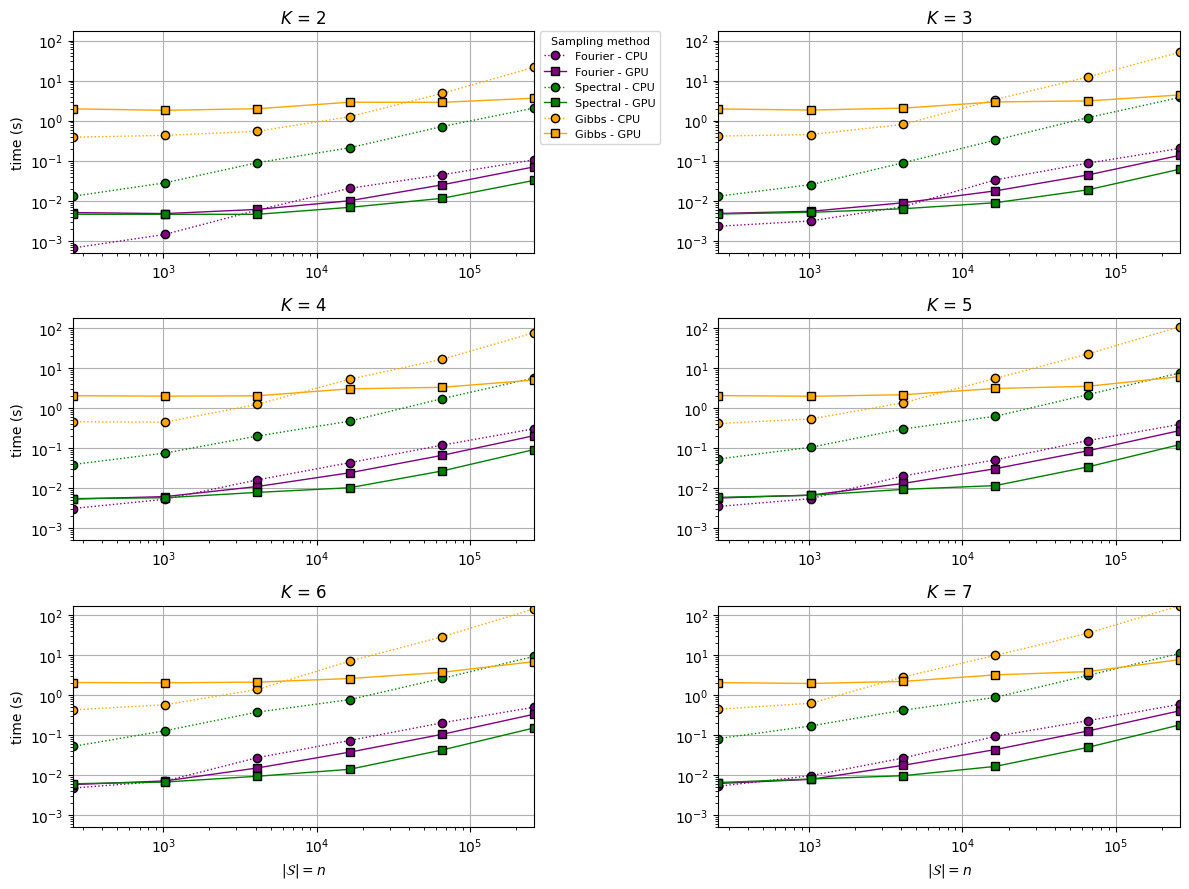

In [ ]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

plt.figure(figsize=(12,9))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (0,1,2,3,4,5):
    plt.subplot(3,2,k+1)
    for i in range(3):
        plt.loglog(size,all_res[2*i,:,k].T,'o:',label=labels[2*i],c=col[i],lw=1,markeredgecolor='k');
        plt.loglog(size,all_res[2*i+1,:,k].T,'s-',label=labels[2*i+1],c=col[i],lw=1,markeredgecolor='k');

    plt.grid()
    if k==0:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025),
                      prop={'size': 8},title_fontsize=8)
    if k%2==0:
        plt.ylabel('time (s)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    if k>3:plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
#plt.savefig(folder+"all_times.pdf")

## Figure 6 : K=2 and K=7 case 

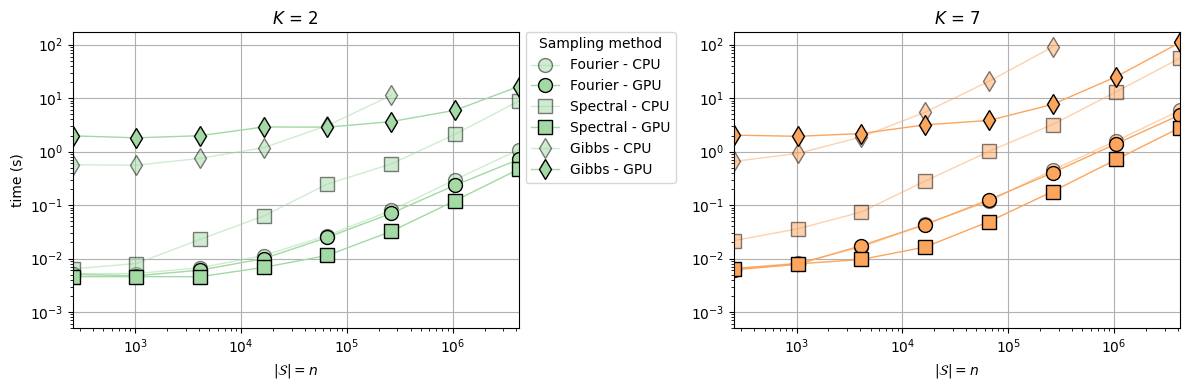

In [56]:
N=6

N = 6

ymin = 0.0005#res.min()
ymax=170#res.max()
labels = np.arange(2,8)

cmap = plt.colormaps['Spectral']
# Take colors at regular intervals spanning the colormap.
colorslist = cmap(np.roll(np.linspace(0,1,N+2),3) )


plt.figure(figsize=(12,4))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))


plt.subplot(1,2,1)
ms = 10
plt.loglog(size,all_res[0,:,0].T,'o-',ms=ms,label=labels[0],c=colorslist[0],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res[1,:,0].T,'o-',ms=ms,label=labels[1],c=colorslist[0],lw=1,markeredgecolor='k');
plt.loglog(size,all_res[2,:,0].T,'s-',ms=ms,label=labels[2],c=colorslist[0],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res[3,:,0].T,'s-',ms=ms,label=labels[3],c=colorslist[0],lw=1,markeredgecolor='k');
plt.loglog(size,all_res[4,:,0].T,'d-',ms=ms,label=labels[4],c=colorslist[0],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res[5,:,0].T,'d-',ms=ms,label=labels[5],c=colorslist[0],lw=1,markeredgecolor='k');
plt.grid()
plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025))#,
#                      prop={'size': 8},title_fontsize=8)
plt.ylabel('time (s)');
plt.xlim(size[0],size[-1])
plt.ylim(ymin,ymax);
plt.xlabel('$|\\mathcal{S}| = n$')
plt.title('$K$ = 2')


plt.subplot(1,2,2)
plt.loglog(size,all_res[0,:,5].T,'o-',ms=ms,label=labels[0],c=colorslist[5],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res[1,:,5].T,'o-',ms=ms,label=labels[1],c=colorslist[5],lw=1,markeredgecolor='k');
plt.loglog(size,all_res[2,:,5].T,'s-',ms=ms,label=labels[2],c=colorslist[5],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res[3,:,5].T,'s-',ms=ms,label=labels[3],c=colorslist[5],lw=1,markeredgecolor='k');
plt.loglog(size,all_res[4,:,5].T,'d-',ms=ms,label=labels[4],c=colorslist[5],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res[5,:,5].T,'d-',ms=ms,label=labels[5],c=colorslist[5],lw=1,markeredgecolor='k');
plt.grid()
plt.xlim(size[0],size[-1])
plt.ylim(ymin,ymax);
plt.xlabel('$|\\mathcal{S}| = n$')
plt.title('$K$ = 7')

#plt.ylabel('time (s)');
plt.tight_layout()
plt.savefig(folder+"all_times_smol_v2.pdf")

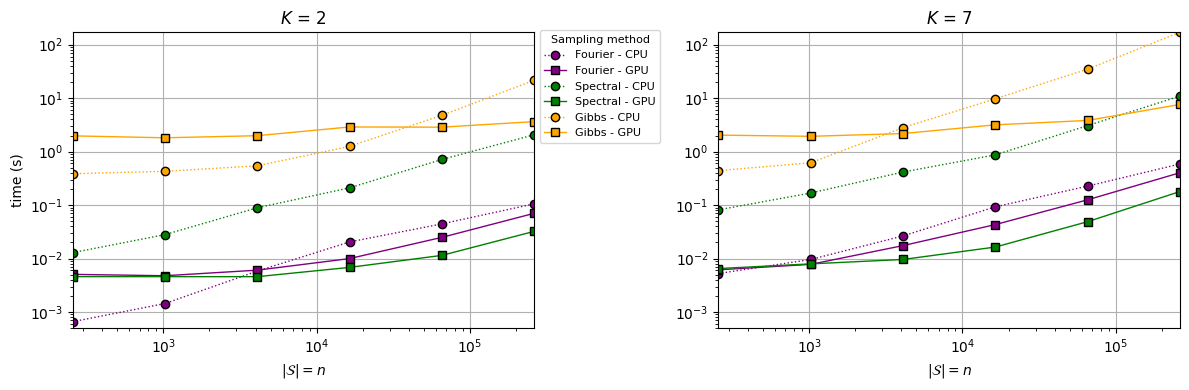

In [63]:

ymin = 0.0005#res.min()
ymax=170#res.max()

ik = 1


plt.figure(figsize=(12,4))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (0,5):
    if k==0:     plt.subplot(1,2,1)
    if k==5:plt.subplot(1,2,2)
    for i in range(3):
        plt.loglog(size,all_res[2*i,:,k].T,'o:',label=labels[2*i],c=col[i],lw=1,markeredgecolor='k');
        plt.loglog(size,all_res[2*i+1,:,k].T,'s-',label=labels[2*i+1],c=col[i],lw=1,markeredgecolor='k');

    plt.grid()
    if k==0:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025),
                      prop={'size': 8},title_fontsize=8)
    if k%2==0:
        plt.ylabel('time (s)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
#plt.savefig(folder+"all_times_smol.pdf")

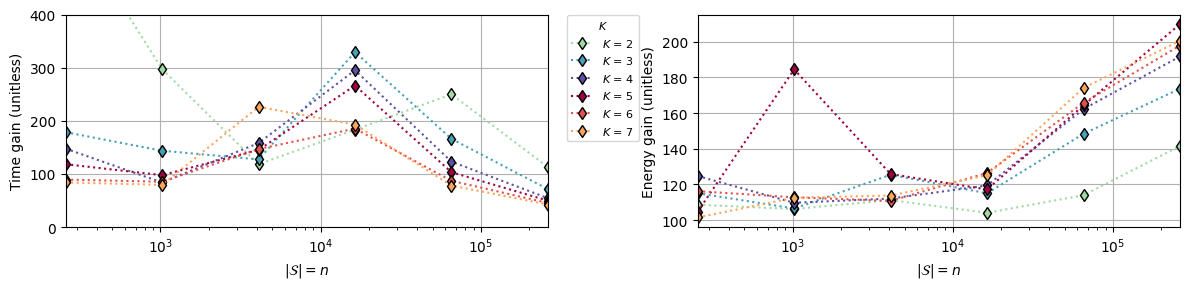

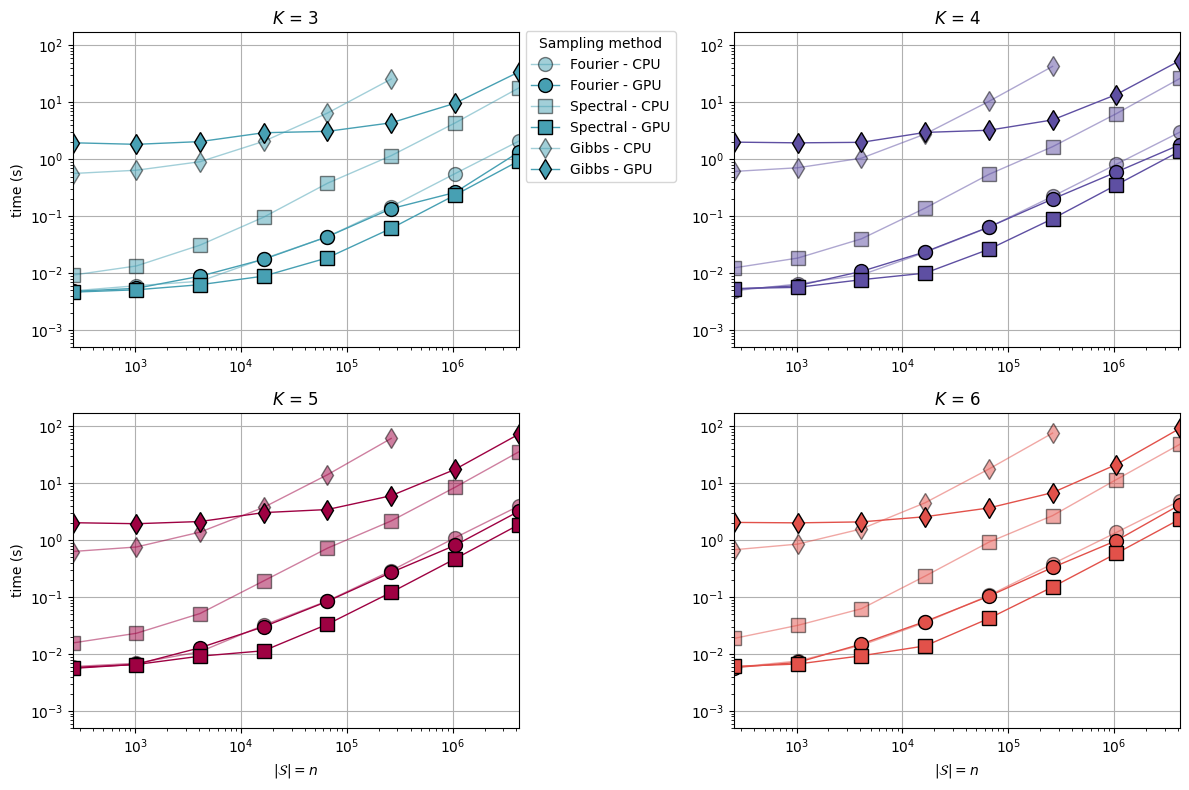

In [57]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

plt.figure(figsize=(12,8))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (1,2,3,4):
    plt.subplot(2,2,k)

    plt.loglog(size,all_res[0,:,k].T,'o-',ms=ms,label=labels[0],c=colorslist[k],lw=1,markeredgecolor='k',alpha=0.5);
    plt.loglog(size,all_res[1,:,k].T,'o-',ms=ms,label=labels[1],c=colorslist[k],lw=1,markeredgecolor='k');
    plt.loglog(size,all_res[2,:,k].T,'s-',ms=ms,label=labels[2],c=colorslist[k],lw=1,markeredgecolor='k',alpha=0.5);
    plt.loglog(size,all_res[3,:,k].T,'s-',ms=ms,label=labels[3],c=colorslist[k],lw=1,markeredgecolor='k');
    plt.loglog(size,all_res[4,:,k].T,'d-',ms=ms,label=labels[4],c=colorslist[k],lw=1,markeredgecolor='k',alpha=0.5);
    plt.loglog(size,all_res[5,:,k].T,'d-',ms=ms,label=labels[5],c=colorslist[k],lw=1,markeredgecolor='k');

    plt.grid()
    if k==1:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025))
                      #prop={'size': 8},title_fontsize=8)
    if k%2==1:
        plt.ylabel('time (s)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    if k>2:plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
plt.savefig(folder+"all_time_ann_v2.pdf")

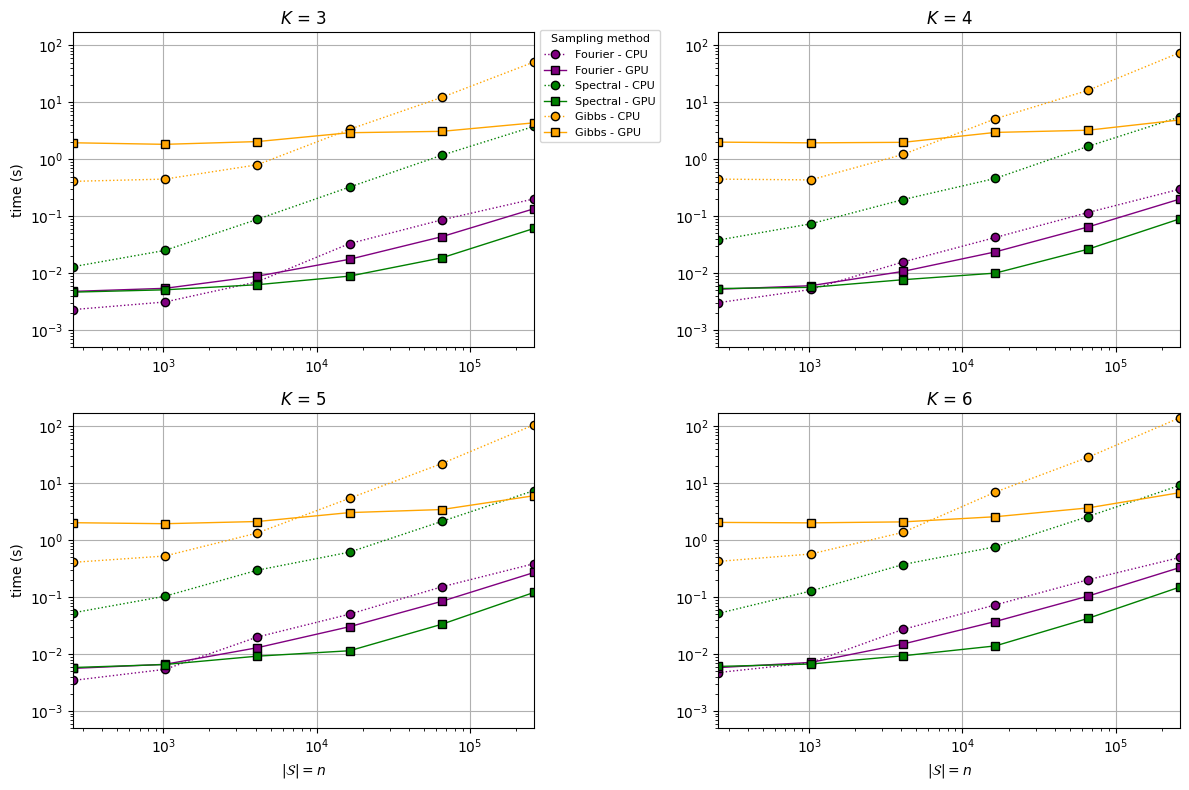

In [14]:

ymin = 0.0005#res.min()
ymax=170#res.max()

ik = 1

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

plt.figure(figsize=(12,8))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (1,2,3,4):
    plt.subplot(2,2,k)
    
    for i in range(3):
        plt.loglog(size,all_res[2*i,:,k].T,'o:',label=labels[2*i],c=col[i],lw=1,markeredgecolor='k');
        plt.loglog(size,all_res[2*i+1,:,k].T,'s-',label=labels[2*i+1],c=col[i],lw=1,markeredgecolor='k');

    plt.grid()
    if k==1:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025),
                      prop={'size': 8},title_fontsize=8)
    if k%2==1:
        plt.ylabel('time (s)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    if k>2:plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
plt.savefig(folder+"all_times_ann.pdf")

# Figure 7 / 10 : energy results 

## Figure 7 : K = 2 and K= = 7 cases 

In [87]:
import pandas as pd

N = 6


labels = np.arange(2,8)

df_FC = pd.read_csv('./measures/GUMSampler_fourier_CPU_time.csv')
df_FG = pd.read_csv('./measures/GUMSampler_fourier_GPU_energy.csv')
df_SC = pd.read_csv('./measures/GUMSampler_spectral_CPU_time.csv')
df_SG = pd.read_csv('./measures/GUMSampler_spectral_GPU_energy.csv')
df_GC = pd.read_csv('./measures/Gibbs_sampler_CPU_time.csv')
df_GG = pd.read_csv('./measures/Gibbs_sampler_GPU_energy.csv')

res = df_FC.to_numpy()[:,1:]
size=df_FC.to_numpy()[:,0]
Ns, Nk = res.shape

all_res_e = np.zeros(shape=(6,Ns,Nk))
all_res_e[0] = df_FC.to_numpy()[:,1:]
all_res_e[1] = df_FG.to_numpy()[:,1:]
all_res_e[2] = df_SC.to_numpy()[:,1:]
all_res_e[3] = df_SG.to_numpy()[:,1:]
all_res_e[4] = df_GC.to_numpy()[:,1:]
all_res_e[5] = df_GG.to_numpy()[:,1:]

#size = df.to_numpy()[:,0]

ymin = 1e-3#0.0005#res.min()
ymax=210#170#res.max()

ik = 1

In [59]:
import pandas as pd

N = 6


labels = np.arange(2,8)

Ns = 8
Nk = 6
all_res_e = np.zeros(shape=(6,Ns,Nk))+np.nan

df_FC = pd.read_csv('./measures/old/GUMSampler_fourier_CPU_energy.csv')
df_FCx = pd.read_csv('./measures/GUMSampler_fourier_CPU_energy.csv')

df_FG = pd.read_csv('./measures/old/GUMSampler_fourier_GPU_energy.csv')
df_FGx = pd.read_csv('./measures/GUMSampler_fourier_GPU_energy.csv')

df_SC = pd.read_csv('./measures/old/GUMSampler_spectral_CPU_energy.csv')
df_SCx = pd.read_csv('./measures/GUMSampler_spectral_CPU_energy.csv')

df_SG = pd.read_csv('./measures/old/GUMSampler_spectral_GPU_energy.csv')
df_SGx = pd.read_csv('./measures/GUMSampler_spectral_GPU_energy.csv')

df_GC = pd.read_csv('./measures/Gibbs_sampler_CPU_energy.csv')

df_GG = pd.read_csv('./measures/old/Gibbs_sampler_GPU_energy.csv')
df_GGx = pd.read_csv('./measures/Gibbs_sampler_GPU_energy.csv')

all_res_e[0] = np.concatenate((df_FC.to_numpy()[:,1:],df_FCx.to_numpy()[:,1:]),axis=0) # Fourier, CPU
all_res_e[1] = np.concatenate((df_FG.to_numpy()[:,1:],df_FGx.to_numpy()[:,1:]),axis=0) # FOurier, GPU
all_res_e[2] = np.concatenate((df_SC.to_numpy()[:,1:],df_SCx.to_numpy()[:,1:]),axis=0) # Spectral, CPU
all_res_e[3] = np.concatenate((df_SG.to_numpy()[:,1:],df_SGx.to_numpy()[:,1:]),axis=0) # Spectral, CPU
all_res_e[4,:6] = df_GC.to_numpy()[:,1:]
all_res_e[5] = np.concatenate((df_GG.to_numpy()[:,1:],df_GGx.to_numpy()[:,1:]),axis=0) # Spectral, CPU

size = np.concatenate((df_FC.to_numpy()[:,0],np.array([1024**2,2048**2])),axis=0)

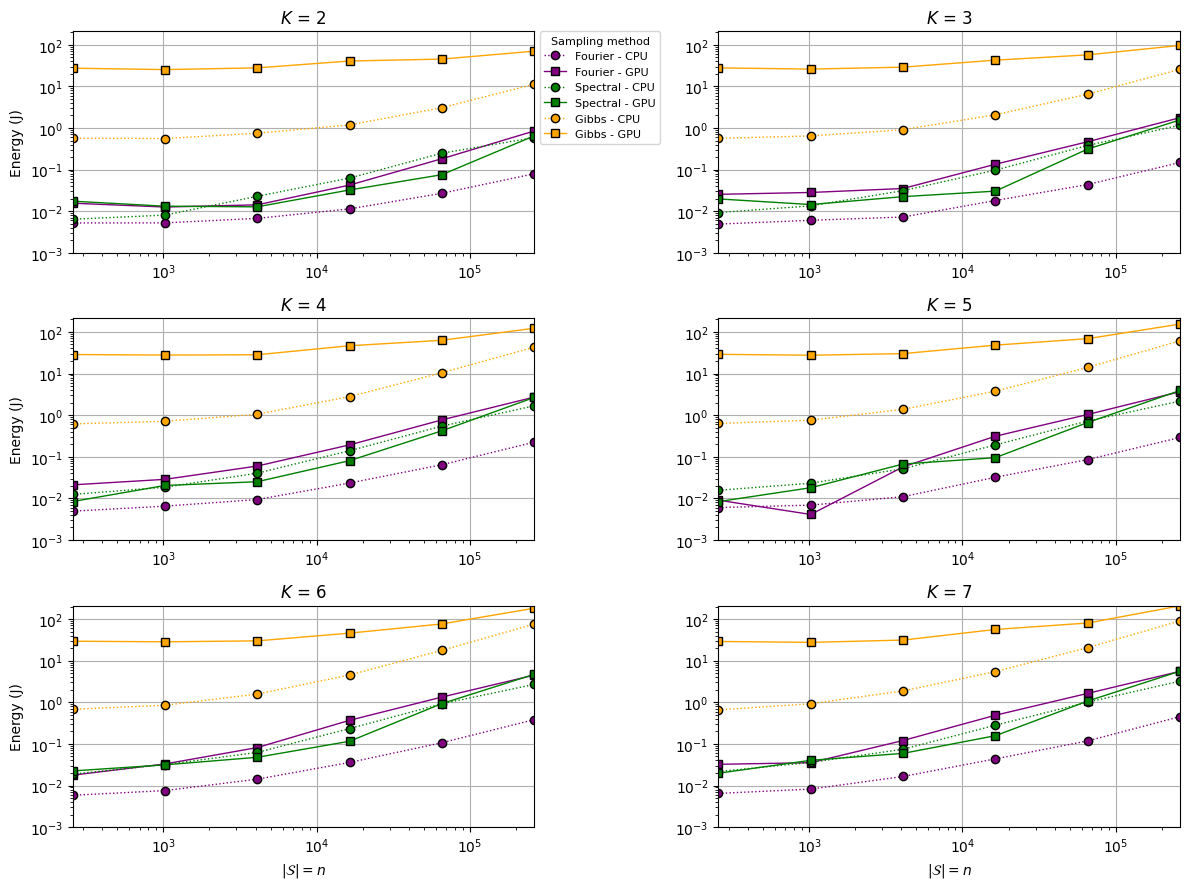

In [ ]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

plt.figure(figsize=(12,9))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (0,1,2,3,4,5):
    plt.subplot(3,2,k+1)
    for i in range(3):
        plt.loglog(size,all_res_e[2*i,:,k].T,'o:',label=labels[2*i],c=col[i],lw=1,markeredgecolor='k');
        plt.loglog(size,all_res_e[2*i+1,:,k].T,'s-',label=labels[2*i+1],c=col[i],lw=1,markeredgecolor='k');

    plt.grid()
    if k==0:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025),
                      prop={'size': 8},title_fontsize=8)
    if k%2==0:
        plt.ylabel('Energy (J)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    if k>3:plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
#plt.savefig(folder+"all_energy.pdf")

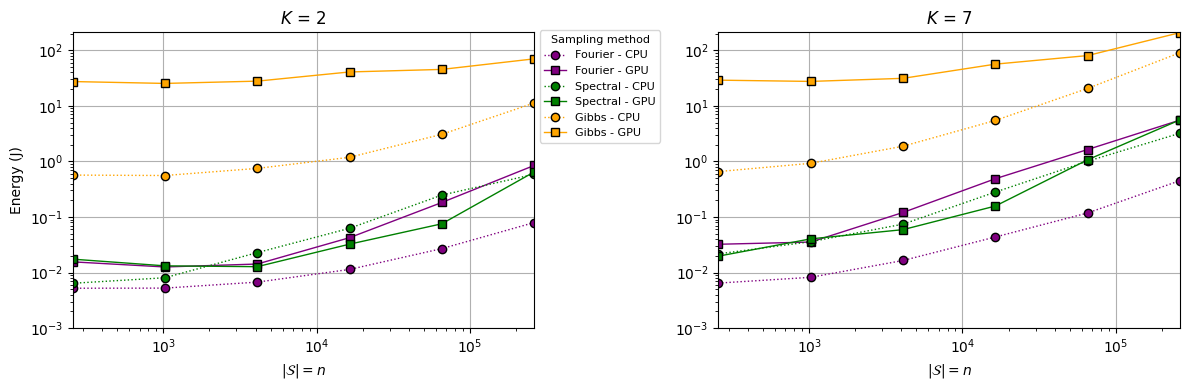

In [9]:

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

plt.figure(figsize=(12,4))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (0,5):
    if k==0:plt.subplot(1,2,1)
    else: plt.subplot(1,2,2)   
    for i in range(3):
        plt.loglog(size,all_res_e[2*i,:,k].T,'o:',label=labels[2*i],c=col[i],lw=1,markeredgecolor='k');
        plt.loglog(size,all_res_e[2*i+1,:,k].T,'s-',label=labels[2*i+1],c=col[i],lw=1,markeredgecolor='k');

    plt.grid()
    if k==0:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025),
                      prop={'size': 8},title_fontsize=8)
    if k%2==0:
        plt.ylabel('Energy (J)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
plt.savefig(folder+"all_energy_smol.pdf")

In [64]:
all_res_e[np.isnan(all_res_e)==0].max()

3732.495500000002

In [65]:
ymin

nan

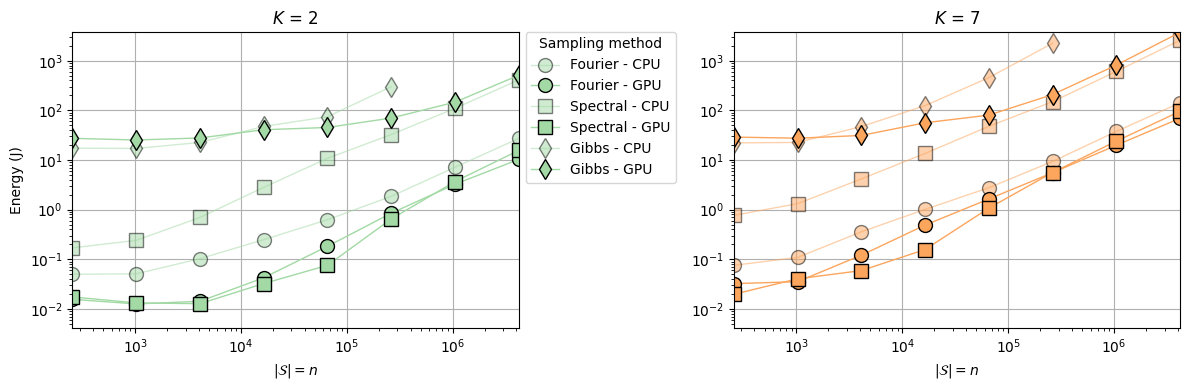

In [66]:
N=6
cmap = plt.colormaps['Spectral']
# Take colors at regular intervals spanning the colormap.
colorslist = cmap(np.roll(np.linspace(0,1,N+2),3) )

ymin = all_res_e[np.isnan(all_res_e)==0].min()
ymax = all_res_e[np.isnan(all_res_e)==0].max()
plt.figure(figsize=(12,4))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))


plt.subplot(1,2,1)
ms = 10
plt.loglog(size,all_res_e[0,:,0].T,'o-',ms=ms,label=labels[0],c=colorslist[0],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res_e[1,:,0].T,'o-',ms=ms,label=labels[1],c=colorslist[0],lw=1,markeredgecolor='k');
plt.loglog(size,all_res_e[2,:,0].T,'s-',ms=ms,label=labels[2],c=colorslist[0],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res_e[3,:,0].T,'s-',ms=ms,label=labels[3],c=colorslist[0],lw=1,markeredgecolor='k');
plt.loglog(size,all_res_e[4,:,0].T,'d-',ms=ms,label=labels[4],c=colorslist[0],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res_e[5,:,0].T,'d-',ms=ms,label=labels[5],c=colorslist[0],lw=1,markeredgecolor='k');
plt.grid()
plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025))#,
#                      prop={'size': 8},title_fontsize=8)
plt.ylabel('Energy (J)');
plt.xlim(size[0],size[-1])
plt.ylim(ymin,ymax);
plt.xlabel('$|\\mathcal{S}| = n$')
plt.title('$K$ = 2')


plt.subplot(1,2,2)
plt.loglog(size,all_res_e[0,:,5].T,'o-',ms=ms,label=labels[0],c=colorslist[5],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res_e[1,:,5].T,'o-',ms=ms,label=labels[1],c=colorslist[5],lw=1,markeredgecolor='k');
plt.loglog(size,all_res_e[2,:,5].T,'s-',ms=ms,label=labels[2],c=colorslist[5],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res_e[3,:,5].T,'s-',ms=ms,label=labels[3],c=colorslist[5],lw=1,markeredgecolor='k');
plt.loglog(size,all_res_e[4,:,5].T,'d-',ms=ms,label=labels[4],c=colorslist[5],lw=1,markeredgecolor='k',alpha=0.5);
plt.loglog(size,all_res_e[5,:,5].T,'d-',ms=ms,label=labels[5],c=colorslist[5],lw=1,markeredgecolor='k');
plt.grid()
plt.xlim(size[0],size[-1])
plt.ylim(ymin,ymax);
plt.xlabel('$|\\mathcal{S}| = n$')
plt.title('$K$ = 7')

#plt.ylabel('time (s)');
plt.tight_layout()
plt.savefig(folder+"all_energy_smol_v2.pdf")

## Figure 10 (b) : complimentary results

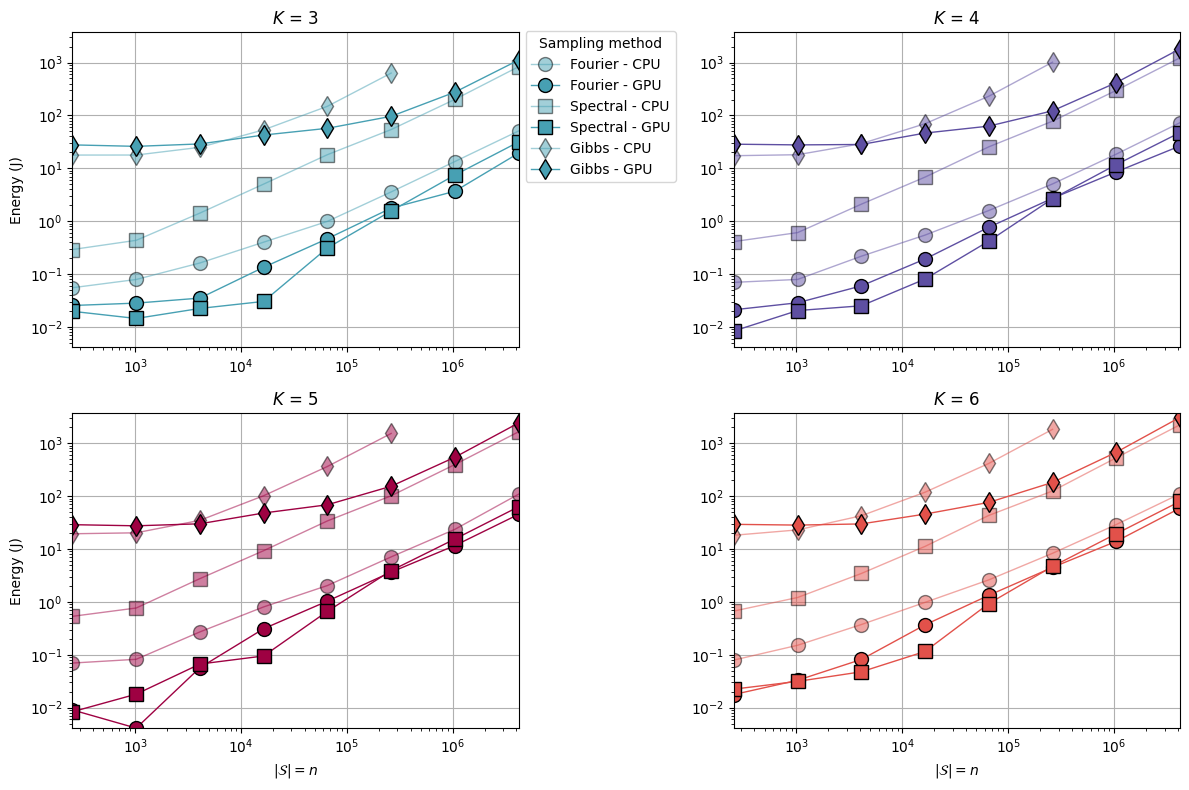

In [67]:

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

plt.figure(figsize=(12,8))

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

col= ('purple','green','orange')
for k in (1,2,3,4):
    plt.subplot(2,2,k)

    plt.loglog(size,all_res_e[0,:,k].T,'o-',ms=ms,label=labels[0],c=colorslist[k],lw=1,markeredgecolor='k',alpha=0.5);
    plt.loglog(size,all_res_e[1,:,k].T,'o-',ms=ms,label=labels[1],c=colorslist[k],lw=1,markeredgecolor='k');
    plt.loglog(size,all_res_e[2,:,k].T,'s-',ms=ms,label=labels[2],c=colorslist[k],lw=1,markeredgecolor='k',alpha=0.5);
    plt.loglog(size,all_res_e[3,:,k].T,'s-',ms=ms,label=labels[3],c=colorslist[k],lw=1,markeredgecolor='k');
    plt.loglog(size,all_res_e[4,:,k].T,'d-',ms=ms,label=labels[4],c=colorslist[k],lw=1,markeredgecolor='k',alpha=0.5);
    plt.loglog(size,all_res_e[5,:,k].T,'d-',ms=ms,label=labels[5],c=colorslist[k],lw=1,markeredgecolor='k');

    plt.grid()
    if k==1:plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025))
                      #prop={'size': 8},title_fontsize=8)
    if k%2==1:
        plt.ylabel('Energy (J)');
    plt.xlim(size[0],size[-1])
    plt.ylim(ymin,ymax);
    if k>2:plt.xlabel('$|\\mathcal{S}| = n$')
    plt.title('$K$ = '+str(k+2))

#plt.ylabel('time (s)');
plt.tight_layout()
plt.savefig(folder+"all_energy_ann_v2.pdf")

# Figure 8

## (a) Improvements in time and energy

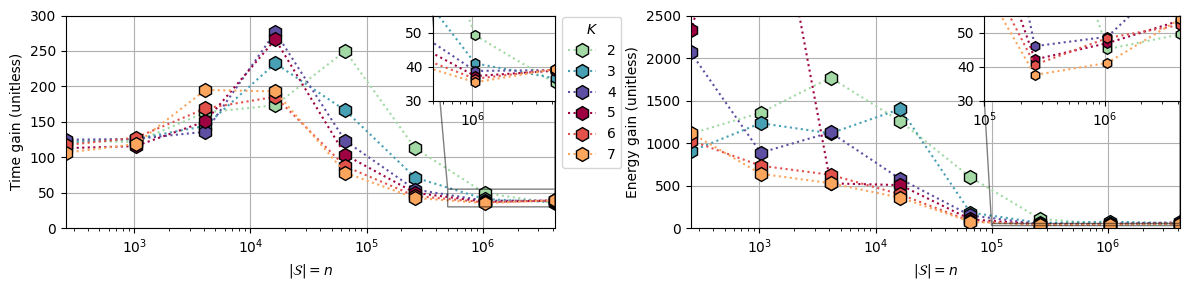

In [174]:
## A look at the ratios

#for i in range(3):
#    plt.loglog(size,all_res[2*i,:,k].T,'o:',label=labels[2*i],c=col[i],lw=1,markeredgecolor='k');
#    plt.loglog(size,all_res[2*i+1,:,k].T,'s-',label=labels[2*i+1],c=col[i],lw=1,markeredgecolor='k');
#



plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))


x1, x2, y1, y2 = 5*1e5, size[-1], 30, 55  # subregion of the original image


plt.figure(figsize=(12,3))

ax1=plt.subplot(1,2,1)
axins = ax1.inset_axes([0.75, 0.6, 0.25, 0.4],xlim=(x1, x2), ylim=(y1, y2))#, xticklabels=[], yticklabels=[])
for k in range(6):#k=0
    best_gibbs = np.nanmin(all_res[4:,:,k],axis=0)
    best_dgum = np.nanmin(all_res[:4,:,k],axis=0)
    
    ax1.semilogx(size,best_gibbs/best_dgum,'h:',ms=10,label=str(k+2),markeredgecolor='k')#+" - %.2f"%((best_gibbs/best_dgum).mean()))
    axins.semilogx(size,best_gibbs/best_dgum,'h:',ms=7,label=str(k+2),markeredgecolor='k')#+" - %.2f"%((best_gibbs/best_dgum).mean()))
    
    plt.ylabel('Time gain (unitless)')
    #print("Temps " + str((best_gibbs/best_dgum).min()))
plt.legend(title='$K$',
                       bbox_to_anchor=(1.15, 1.025))
#                      prop={'size': 8},title_fontsize=8)
plt.ylim(0,300)
axins.grid()
axins.set_xticklabels([],minor=True)
ax1.indicate_inset_zoom(axins, edgecolor="k")


ax2=plt.subplot(1,2,2)
x1, x2, y1, y2 = 1*1e5, size[-1], 30, 55  # subregion of the original image

axins2 = ax2.inset_axes([0.6, 0.6, 0.4, 0.4],xlim=(x1, x2), ylim=(y1, y2))#, xticklabels=[], yticklabels=[])
for k in range(6):#k=0
    best_gibbs = np.nanmin(all_res_e[4:,:,k],axis=0)
    best_dgum = np.nanmin(all_res_e[:4,:,k],axis=0)
    ax2.semilogx(size,best_gibbs/best_dgum,'h:',ms=10,markeredgecolor='k')#,label="$K$ = "+str(k+2)+" - %.2f"%((best_gibbs/best_dgum).mean()))
    axins2.semilogx(size,best_gibbs/best_dgum,'h:',ms=7,markeredgecolor='k')
    plt.ylabel('Energy gain (unitless)')
    #print("Energie " + str((best_gibbs/best_dgum).min()))
plt.ylim(0,2500)
for i in (1,2):
    plt.subplot(1,2,i)
    plt.grid()
    plt.xlim(size[0],size[-1])
#    #plt.ylim(1,None);
    plt.xlabel('$|\\mathcal{S}| = n$');

axins2.grid()
ax2.indicate_inset_zoom(axins2, edgecolor="k")
plt.tight_layout()


plt.savefig(folder+"gain_times_energy.pdf")

Temps 35.22609513548587
Temps 36.510731932588484
Temps 38.70523824901915
Temps 37.210314719342485
Temps 36.405204119007635
Temps 35.3823373799451
Energie 45.11045473364157
Energie 57.58425423632636
Energie 45.9849943587848
Energie 42.08005247550877
Energie 40.50637783765232
Energie 37.50666577609077


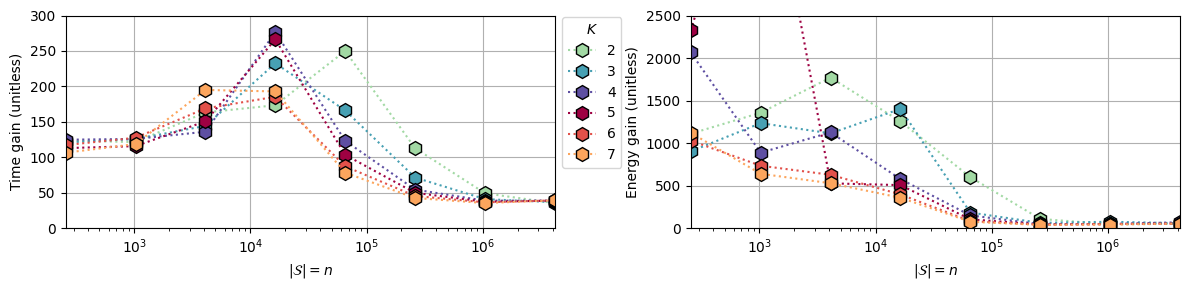

In [ ]:
plt.subplot(1,2,2)
for k in range(6):#k=0
    best_gibbs = np.nanmin(all_res_e[4:,:,k],axis=0)
    best_dgum = np.nanmin(all_res_e[:4,:,k],axis=0)
    plt.semilogx(size,best_gibbs/best_dgum,'h:',ms=10,markeredgecolor='k')#,label="$K$ = "+str(k+2)+" - %.2f"%((best_gibbs/best_dgum).mean()))
    plt.ylabel('Energy gain (unitless)')
    print("Energie " + str((best_gibbs/best_dgum).min()))
plt.ylim(0,2500)
for i in (1,2):
    plt.subplot(1,2,i)
    plt.grid()
#    
#        
    plt.xlim(size[0],size[-1])
#    #plt.ylim(1,None);
    plt.xlabel('$|\\mathcal{S}| = n$');
plt.tight_layout()
plt.savefig(folder+"gain_times_energy.pdf")

## (b) energy vs time tradeoff

In [55]:
np.sqrt(size[-1]),np.sqrt(size[-4])

(512.0, 64.0)

In [39]:
all_res.shape

(6, 6, 6)

In [ ]:
k = 3

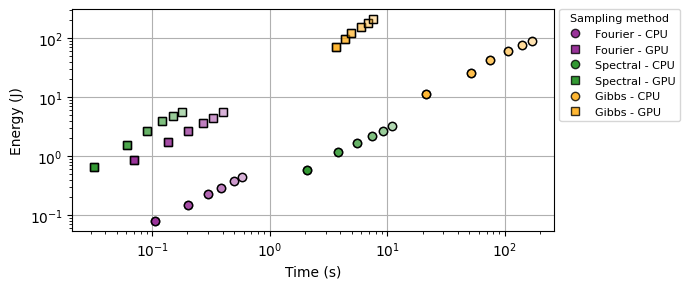

In [89]:

plt.figure(figsize=(7,3))

#plt.subplot(1,2,2)
for n in range(6):
    for i in range(3):
        plt.loglog(all_res[2*i,-1,n].T,all_res_e[2*i,-1,n].T,'o',label=labels[2*i],c=col[i],lw=1,alpha=1-(0.2+0.1*n),markeredgecolor='k');
        plt.loglog(all_res[2*i,-1,n].T,all_res_e[2*i,-1,n].T,'o',markerfacecolor="None",lw=1,markeredgecolor='k');
        plt.loglog(all_res[2*i+1,-1,n].T,all_res_e[2*i+1,-1,n].T,'s',label=labels[2*i+1], c=col[i],lw=1,alpha=1-(0.2+0.1*n),markeredgecolor='k',);
        plt.loglog(all_res[2*i+1,-1,n].T,all_res_e[2*i+1,-1,n].T,'s',markerfacecolor="None",lw=2,markeredgecolor='k');
    if n==0 : plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025),
                      prop={'size': 8},title_fontsize=8)
#plt.loglog(all_res[2*i,-1,n].T,all_res_e[2*i,-1,n].T,'o',label=labels[2*i],markerfacecolor="None",lw=1,markeredgecolor='k');
#plt.loglog(all_res[2*i+1,-1,n].T,all_res_e[2*i+1,-1,n].T,'s',label=labels[2*i+1],markerfacecolor="None",lw=2,markeredgecolor='k');
    
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
#plt.title('N = '+str(int(size[-1])))
#plt.xlim(3*1e-3,5*1e2)
#plt.ylim(3*1e-3,5*1e2)
#plt.title('$N = 512 \\times 512$')

#plt.subplot(1,2,1)
#for n in range(6):
#    for i in range(3):
#        
#        plt.loglog(all_res[2*i,-4,n].T,all_res_e[2*i,-4,n].T,'o',c=col[i],lw=1,alpha=0.2+0.1*n);
#        plt.loglog(all_res[2*i,-4,n].T,all_res_e[2*i,-4,n].T,'o',markerfacecolor="None",lw=1,markeredgecolor='k',label='CPU');
#        
#        plt.loglog(all_res[2*i+1,-4,n].T,all_res_e[2*i+1,-4,n].T,'s',c=col[i],lw=1,alpha=0.2+0.1*n,markeredgecolor='k',);
#        plt.loglog(all_res[2*i+1,-4,n].T,all_res_e[2*i+1,-4,n].T,'s',markerfacecolor="None",lw=1,markeredgecolor='k',label='GPU');
#        if n==0 and i==0: plt.legend()     
#plt.grid()
#sN = np.sqrt(size[-4])
#plt.title('$N = 64 \\times 64$')#+str(int(size[-4])))
#plt.xlabel('Time (s)')
##plt.ylabel('Energy (J)')
#plt.xlim(3*1e-3,5*1e2)
#plt.ylim(3*1e-3,5*1e2)
plt.tight_layout()
#plt.savefig(folder+"energy_vs_time.pdf")

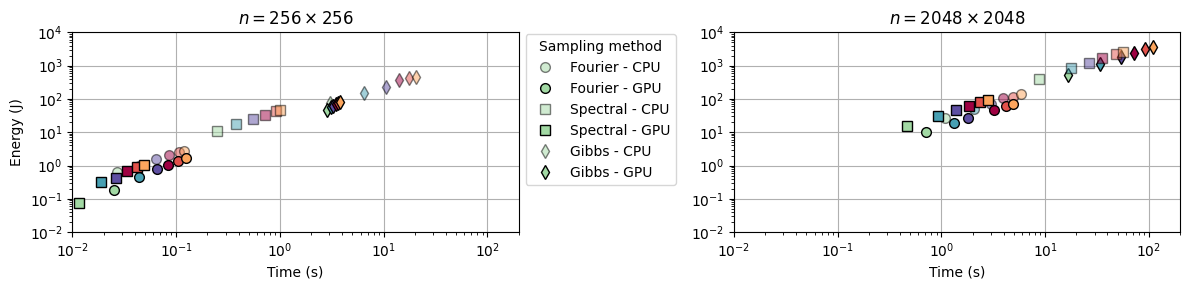

In [99]:
N=6
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Spectral(np.roll(np.linspace(0,1,N+2),3)))

cmap = plt.colormaps['Spectral']
colors = cmap(np.roll(np.linspace(0,1,N+2),3))

markers=('o','s','d')

labels=('Fourier - CPU', 'Fourier - GPU',
              'Spectral - CPU', 'Spectral - GPU',
              'Gibbs - CPU', 'Gibbs - GPU')

ms = 7

plt.figure(figsize=(12,3))

plt.subplot(1,2,1)

index = -4
for n in range(6):
    for i in range(3):

        plt.loglog(all_res[2*i,index,n].T,all_res_e[2*i,index,n].T,markers[i],ms=ms,label=labels[2*i],color=colors[n],lw=1,markeredgecolor='k',alpha=0.5);
        plt.loglog(all_res[2*i+1,index,n].T,all_res_e[2*i+1,index,n].T,markers[i],ms=ms,label=labels[2*i+1],color=colors[n],lw=2,markeredgecolor='k');
        
        if n==0 : plt.legend(title='Sampling method',
                       bbox_to_anchor=(1., 1.025))
                      #prop={'size': 8},title_fontsize=8)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.title('$n = 256 \\times 256$')
plt.xlim(1e-2,2*1e2)
plt.ylim(1e-2,1e4)
plt.subplot(1,2,2)

index = -1
for n in range(6):
    for i in range(3):

        plt.loglog(all_res[2*i,index,n].T,all_res_e[2*i,index,n].T,markers[i],ms=ms,label=labels[2*i],color=colors[n],lw=1,markeredgecolor='k',alpha=0.5);
        plt.loglog(all_res[2*i+1,index,n].T,all_res_e[2*i+1,index,n].T,markers[i],ms=ms,label=labels[2*i+1],color=colors[n],lw=2,markeredgecolor='k');

plt.grid()
plt.title('$n = 2048 \\times 2048$')
plt.xlabel('Time (s)')
plt.xlim(1e-2,2*1e2) ; plt.ylim(1e-2,1e4)
plt.tight_layout()
plt.savefig(folder+"energy_vs_time_v3.pdf")

In [94]:
size[-4]**0.5

256.0

# Figure 9 : second order statistics

In [24]:
import pandas as pd
df_FG2 = pd.read_csv('proba_with_d_GUM_Fourier.csv')
df_FS2 = pd.read_csv('proba_with_d_GUM_Spectral.csv')
df_GS2 = pd.read_csv('proba_with_d_mrf_gibbs.csv')

dist = np.array(df_FG2.iloc[:,0])
nD = dist.size
proba_K2 = np.zeros(shape=(3,nD))
proba_K2[0] =np.array(df_FG2.iloc[:,1])
proba_K2[1] =np.array(df_FS2.iloc[:,1])
proba_K2[2] =np.array(df_GS2.iloc[:,1])

df_FG2 = pd.read_csv('proba_with_d_GUM_Fourier_K7.csv')
df_FS2 = pd.read_csv('proba_with_d_GUM_Spectral_K7.csv')
df_GS2 = pd.read_csv('proba_with_d_mrf_gibbs_K7.csv')

dist = np.array(df_FG2.iloc[:,0])
nD = dist.size
proba_K7 = np.zeros(shape=(3,nD))
proba_K7[0] =np.array(df_FG2.iloc[:,1])
proba_K7[1] =np.array(df_FS2.iloc[:,1])
proba_K7[2] =np.array(df_GS2.iloc[:,1])

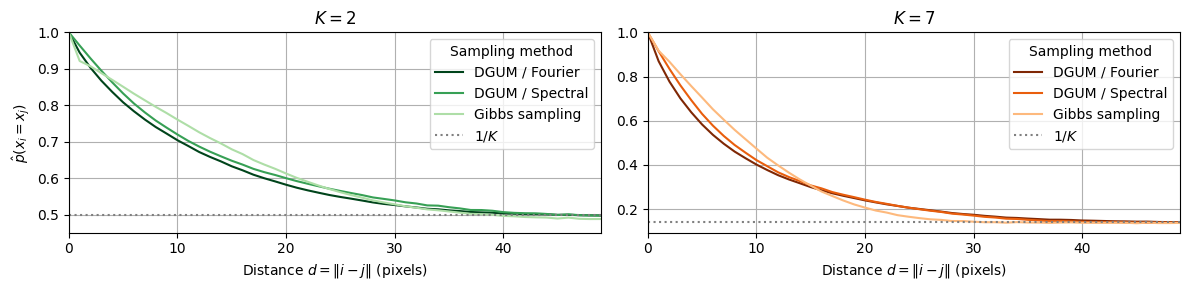

In [107]:
N=4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Greens_r(np.linspace(0,1,N)))

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(dist,proba_K2.T,label=('DGUM / Fourier','DGUM / Spectral','Gibbs sampling'))
plt.plot(dist,0.5*np.ones_like(dist), ':',c='gray',label='$1/K$')
plt.legend(title='Sampling method')#, bbox_to_anchor=(1.31, 1.025),
                      #prop={'size': 8},title_fontsize=8)
plt.xlim(dist.min(),dist.max())
plt.ylim(0.45,1)
plt.ylabel('$\\hat{p}(x_i = x_j)$')
plt.grid()
plt.title('$K=2$')
plt.xlabel('Distance $d = \\|i - j\\|$ (pixels)')
plt.tight_layout()

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Oranges_r(np.linspace(0,1,N)))

plt.subplot(1,2,2)
plt.plot(dist,proba_K7.T,label=('DGUM / Fourier','DGUM / Spectral','Gibbs sampling'))
plt.plot(dist,1/7*np.ones_like(dist), ':',c='gray',label='$1/K$')
plt.xlim(dist.min(),dist.max())
plt.legend(title='Sampling method')
plt.ylim(1/7-0.05,1)
#plt.ylabel('$\\hat{p}(x_i = x_j)$')
plt.grid()
plt.title('$K=7$')
plt.xlabel('Distance $d = \\|i - j\\|$ (pixels)')
plt.tight_layout()
plt.savefig(folder+"second_order.pdf")

# Figure 11: phase transition
## (a) Phase transition of the process sampled by the $\pi_i$ 

In [7]:
Nexp = 100
#Nc = 50
Nc = 50

range_c = np.arange(1,Nc+1)
range_c = np.linspace(0.1,4,Nc)#np.exp(np.linspace(-2,4,Nrho))#np.linspace(0.15,10,Nrho)
range_rho = np.array([2.5,5,10,15])#np.linspace(5,15,Nr)
Nr = range_rho.size
range_kappa = np.array([0.1,0.2,0.3,0.4])
Nk = range_kappa.size
all_prop = np.zeros(shape=(Nexp,Nk,Nc))
all_std = np.zeros_like(all_prop)

fun='gau'
P,Q = 200,200
N =2
K = 3

key = jax.random.PRNGKey(1)
for e in range(Nexp):
    np.random.seed(e)
    key = jax.random.split(key,1)[0]
    for i_k,kappa in enumerate(range_kappa):
        Z = sample_3Z(kappa,method='fourier')
        for i_c,c in enumerate(range_c):
            print("seed "+ str(e) + " kappa=" + str(kappa)+" c = " + str(c) + "       ", end='\r')

            _,pi0,_,_ = phi3_det(Z,c)#calc_pi(Z,c)
            
            X = np.random.rand(P,Q) > pi0 # sample from pi(Z)
            
            all_prop[e,i_k,i_c] = (X[1:-1,1:-1] == X[:-2,:-2]).sum() / (P*Q)
            all_std[e,i_k,i_c] = X.std()


/tmp/ipykernel_36367/1646315108.py:8: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=kappa,nu=nu, dim=2)
/tmp/ipykernel_36367/1646315108.py:39: RuntimeWarning: invalid value encountered in divide
  p1 = norm1/total
/tmp/ipykernel_36367/1646315108.py:40: RuntimeWarning: invalid value encountered in divide
  p0 = norm0/total
/tmp/ipykernel_36367/1646315108.py:41: RuntimeWarning: invalid value encountered in divide
  p2 = norm2/total


In [19]:
np.savez('phase_transition.npz',all_prop=all_prop,all_std=all_std)

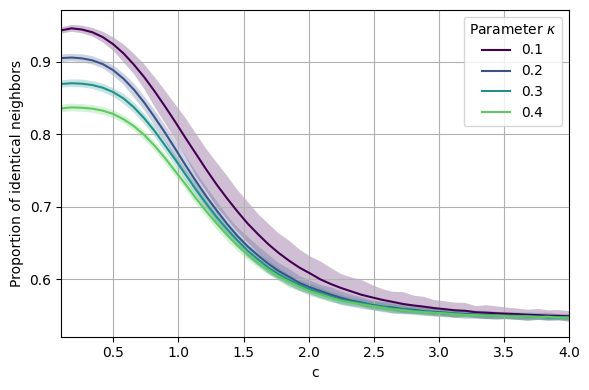

In [24]:
plt.figure(figsize=(6,4))
cmap = plt.colormaps['viridis']
colors = cmap(np.linspace(0, 1, Nk+1))[:-1]

for ik,kappa in enumerate(range_kappa):    
    lower = np.percentile(all_prop[:,ik,:],10,axis=0)
    higher = np.percentile(all_prop[:,ik,:],90,axis=0)
    plt.fill_between(range_c,lower,higher,facecolor=colors[ik],alpha=0.25)
    
for ik,kappa in enumerate(range_kappa):
    moy = all_prop[:,ik,:].mean(axis=0)
    plt.plot(range_c,moy,label=str(kappa),c=colors[ik])

    
    
plt.legend(title='Parameter $\\kappa$')
plt.grid()
plt.xlim(range_c[0],range_c[-1])
plt.ylabel('Proportion of identical neighbors')
plt.xlabel('c')
plt.tight_layout()
plt.savefig('/home/jean-baptiste/Resultats/GUMs/figures/pseudo_phase_pi.pdf')
#plt.fill_between(range_c,all_prop[:,0,:].std(axis=0),':')

In [68]:
kappa = 0.2
i=0
for c in (0.1,2,4):
    Z = sample_3Z(kappa,method='fourier')
    _,pi0,_,_ = phi3_det(Z,c)#calc_pi(Z,c)
    X = np.random.rand(P,Q) > pi0 # sample from pi(Z)
    plt.imsave('/home/jean-baptiste/Resultats/GUMs/figures/pseudo_phase_pi_x'+str(i)+".png",X)
    i+=1

/tmp/ipykernel_36367/1646315108.py:39: RuntimeWarning: invalid value encountered in divide
  p1 = norm1/total
/tmp/ipykernel_36367/1646315108.py:40: RuntimeWarning: invalid value encountered in divide
  p0 = norm0/total
/tmp/ipykernel_36367/1646315108.py:41: RuntimeWarning: invalid value encountered in divide
  p2 = norm2/total


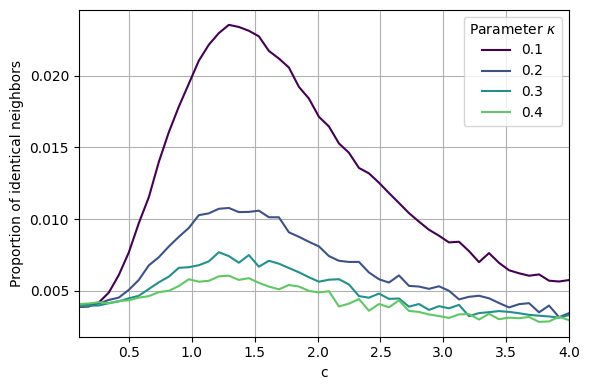

In [10]:
plt.figure(figsize=(6,4))
cmap = plt.colormaps['viridis']
colors = cmap(np.linspace(0, 1, Nk+1))[:-1]

for ik,kappa in enumerate(range_kappa):
    plt.plot(range_c,all_prop[:,ik,:].std(axis=0),label=str(kappa),c=colors[ik])
plt.legend(title='Parameter $\\kappa$')
plt.grid()
plt.xlim(range_c[0],range_c[-1])
plt.ylabel('Std of proportion of identical neighbors')
plt.xlabel('c')
plt.tight_layout()
#plt.savefig('/home/jean-baptiste/Resultats/GUMs/figures/pseudo_phase_pi.pdf')
#plt.fill_between(range_c,all_prop[:,0,:].std(axis=0),':')

## (b) Phase transition when changing $\kappa$

In [7]:
from mrfx.models import GUM
from mrfx.samplers import GUMSampler

In [40]:
#rho = 15 # scale of correlations
Nr = 20
Nexp = 50
range_rho = 10**np.linspace(np.log10(0.1),np.log10(20),Nr)#np.linspace(0.2,15,Nr)
range_K=np.arange(2,8)
Nk = range_K.size

Nka = 50
range_kappa = 10**np.linspace(np.log10(0.01),np.log10(10),Nka)
#np.linspace(0.01,2,Nka)#np.array([0.1,0.2,0.3,0.4])

all_prop_b = np.zeros(shape=(Nexp,Nka,Nk))
all_std_b = np.zeros_like(all_prop_b)

fun='gau'
P,Q = 150,150
N =2
key = jax.random.PRNGKey(123)

#gum_sampler = GUMSampler(lx=P,ly=Q, method="spectral",n_bands=5000)

gum_sampler = GUMSampler(lx=P,ly=Q, method="fourier")


for i_k,K in enumerate(range_K):
    for e in range(Nexp):
        np.random.seed(e*100)
        key = jax.random.split(key,1)[0]
        for i_ka,kappa in enumerate(range_kappa):
            
            print("K = " + str(K) + " seed "+ str(e) + " kappa=" + str(kappa)+ "       ", end='\r')
            gum = GUM(kappa=kappa, K=K, dim=2)
            X = gum_sampler.sample_image(gum, key)[0]
            #X,dists,Z = gums.sample_gum_experimental(K,P,Q,rho)
            
            all_prop_b[e,i_ka,i_k] = (X[1:-1,1:-1] == X[:-2,:-2]).sum() / ((P-2)*(Q-2))
            all_std_b[e,i_ka,i_k] = X.std()


/tmp/ipykernel_10474/991899761.py:32: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gum = GUM(kappa=kappa, K=K, dim=2)


In [37]:
key = jax.random.PRNGKey(123)
key

Array([  0, 123], dtype=uint32)

In [38]:
np.savez('phase_transition_phi.npz',all_prop_b=all_prop_b,all_std_b=all_std_b)

In [28]:
dat = np.load('phase_transition_phi.npz')
all_prop_b = dat.f.all_prop_b
all_std_b = dat.f.all_std_b

mask = all_prop_b==1

#all_prop_b = np.ma.masked_array(all_prop_b,mask=mask)

mask_kappa = mask.sum(axis=(0,2))==0

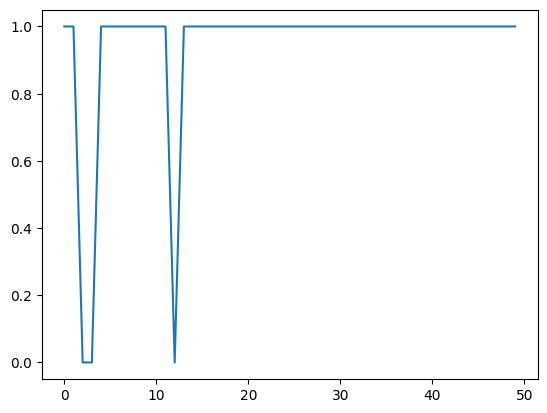

In [29]:
plt.plot(mask_kappa)

In [42]:
mask = all_prop_b==1

#all_prop_b = np.ma.masked_array(all_prop_b,mask=mask)

mask_kappa = mask.sum(axis=(0,2))==0

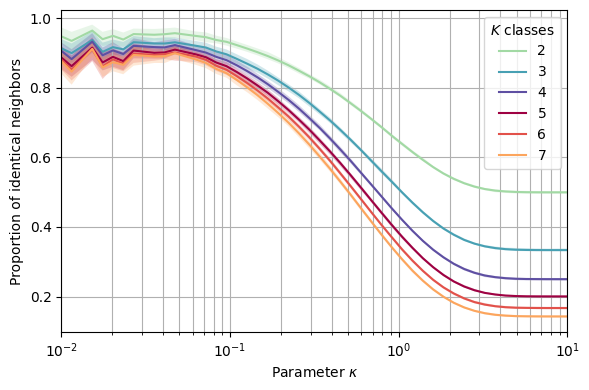

In [46]:
cmap = plt.colormaps['Spectral']
colors = cmap(np.roll(np.linspace(0,1,Nk+2),3))


plt.figure(figsize=(6,4))
#cmap = plt.colormaps['plasma']
#colors = cmap(np.linspace(0, 1, Nk+1))[:-1]

for ik, K in enumerate(range_K):
    plt.semilogx(range_kappa[mask_kappa],np.ma.mean(all_prop_b[:,mask_kappa,ik],axis=0),label=str(K),c=colors[ik])

for ik, K in enumerate(range_K):  
    lower = np.percentile(all_prop_b[:,mask_kappa,ik],10,axis=0)
    higher = np.percentile(all_prop_b[:,mask_kappa,ik],90,axis=0)
    plt.fill_between(range_kappa[mask_kappa],lower,higher,facecolor=colors[ik],alpha=0.25)


plt.legend(title='$K$ classes')
plt.grid(which='both')
plt.xlim(0.01,range_kappa[-1])
plt.ylabel('Proportion of identical neighbors')
plt.xlabel('Parameter $\\kappa$')
plt.tight_layout()
plt.savefig('/home/jean-baptiste/Resultats/GUMs/figures/pseudo_phase_phi_v2.pdf')

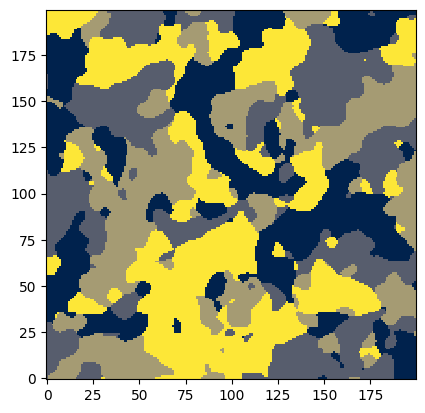

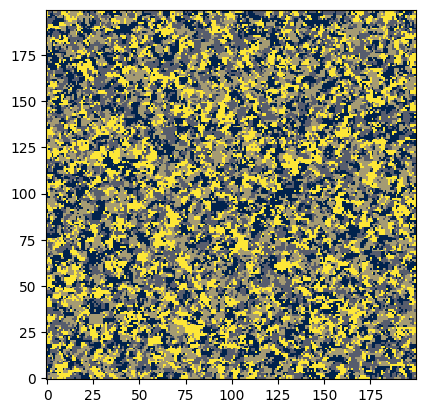

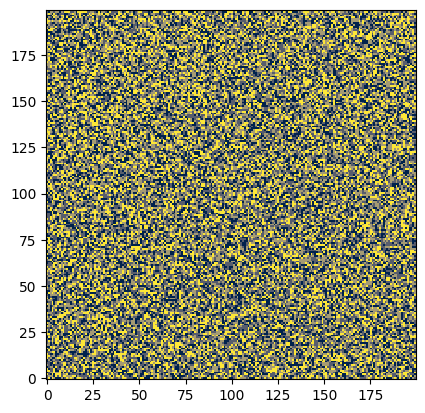

In [69]:
gum_sampler = GUMSampler(lx=P,ly=Q, method="spectral",n_bands=2000)

K = 4
i=0
for kappa in (0.1,1,10):
    gum = GUM(kappa=kappa, K=K, dim=2)
    X = gum_sampler.sample_image(gum, key)[0]
    plt.imshow(X,cmap=plt.cm.cividis);plt.show()

    plt.imsave('/home/jean-baptiste/Resultats/GUMs/figures/pseudo_phase_phi_x'+str(i)+".png",X,cmap=plt.cm.cividis)
    i+=1

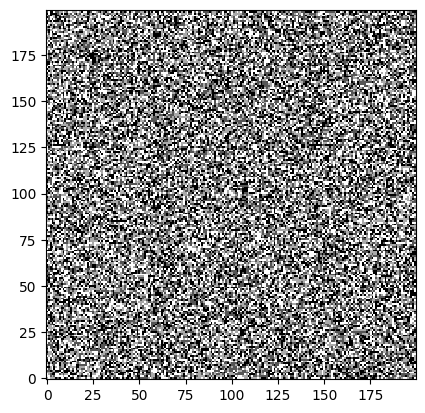

## (c) MRF Phase transition

In [3]:
from mrfx.models import Potts
from mrfx.samplers import GibbsSampler
from mrfx.samplers import ChromaticGibbsSampler


K = 2
beta = 2.75
potts_model = Potts(K=K, beta=beta)

In [12]:

key, subkey = jax.random.split(key, 2)
gibbs = GibbsSampler(lx=P, ly=Q, eps=0.05, max_iter=1000)
X_init, X_list, n_iter = gibbs.run(potts_model, subkey)

Stopping Gibbs sampler, cause: Convergence criterion is reached


In [ ]:
#rho = 15 # scale of correlations
Nexp = 10
range_K=np.arange(2,6)
Nk = range_K.size

Nbeta = 10
range_beta = np.linspace(0.1,3,Nbeta)#10**np.linspace(np.log10(0.01),np.log10(10),Nka)
#np.linspace(0.01,2,Nka)#np.array([0.1,0.2,0.3,0.4])

all_prop_c = np.zeros(shape=(Nexp,Nbeta,Nk))
all_std_c = np.zeros_like(all_prop_c)

P,Q = 200,200
key = jax.random.PRNGKey(1)

gibbs = GibbsSampler(lx=P, ly=Q, eps=0.05, max_iter=1000)

chro_gibbs2 = ChromaticGibbsSampler(
    lx=P, ly=Q, eps=0.05, max_iter=1000, color_update_type="vmap_in_color"
)
#X_init2, X_list2, n_iter2 = chro_gibbs2.run(potts_model, subkey)


for i_k,K in enumerate(range_K):
    for e in range(Nexp):
        np.random.seed(e)
        key = jax.random.split(key,1)[0]
        for i_be,beta in enumerate(range_beta):
            
            print("K = " + str(K) + " seed "+ str(e) + " beta=" + str(beta)+ "       ", end='\r')
            potts_model = Potts(K=K, beta=beta)
            X_init, X_list, n_iter = chro_gibbs2.run(potts_model, key)
            X = X_list[-1].copy()
            #gum = GUM(kappa=kappa, K=K, dim=2)
            #X = gum_sampler.sample_image(gum, key)[0]
            #X,dists,Z = gums.sample_gum_experimental(K,P,Q,rho)
            
            all_prop_c[e,i_be,i_k] = (X[1:-1,1:-1] == X[:-2,:-2]).sum() / ((P-2)*(Q-2))
            all_std_c[e,i_be,i_k] = X.std()


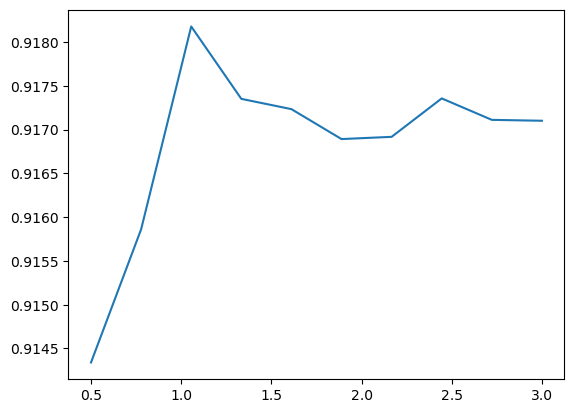

In [22]:
plt.plot(range_beta,all_prop_c[:5,:,0].mean(axis=0))

Stopping Gibbs sampler, cause: Convergence criterion is reached


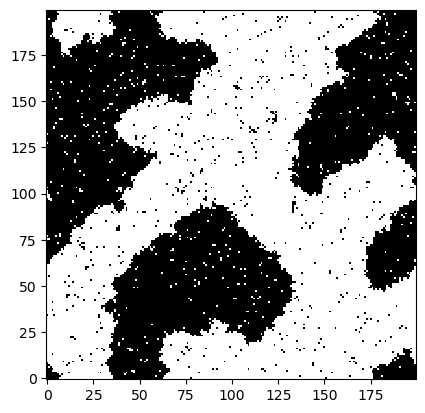

In [19]:
#rho = 15 # scale of correlations
Nexp = 10
range_K=np.arange(2,6)
Nk = range_K.size

Nbeta = 10
range_beta = np.linspace(0.1,3,Nbeta)#10**np.linspace(np.log10(0.01),np.log10(10),Nka)
#np.linspace(0.01,2,Nka)#np.array([0.1,0.2,0.3,0.4])

all_prop_c = np.zeros(shape=(Nexp,Nbeta,Nk))
all_std_c = np.zeros_like(all_prop_c)

P,Q = 200,200
key = jax.random.PRNGKey(1)

gibbs = GibbsSampler(lx=P, ly=Q, eps=0.05, max_iter=1000)

chro_gibbs2 = ChromaticGibbsSampler(
    lx=P, ly=Q, eps=0.05, max_iter=100, color_update_type="vmap_in_color"
)
#X_init2, X_list2, n_iter2 = chro_gibbs2.run(potts_model, subkey)

beta= 0.5
potts_model = Potts(K=K, beta=beta)
X_init, X_list, n_iter = gibbs.run(potts_model, key)
X = X_list[-1].copy()
plt.imshow(X_list[-1])

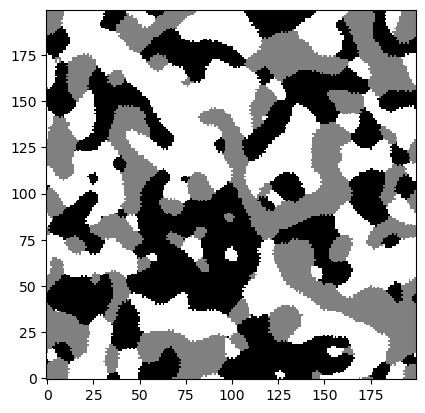

In [21]:
plt.imshow(X_list[-1])

# Figure 9: probability of identical neighbors

In [14]:
def calc_D(X):
    P,Q = X.shape
    dx,dy = np.mgrid[0:P,0:Q]
    dxf, dyf=dx.flatten(),dy.flatten()
    pos = np.array([dxf,dyf]).T

    D = spa.distance_matrix(pos,pos)
    D = np.round(D)
    return D
    
def calc_proba_distance(X,d_max,D=None):
    if D is None:
        print('No D given, please correct for speed...')
        D = calc_D(X)
        
    range_d = np.unique(D[D<d_max])    
    nd = range_d.size
    count_identical = np.zeros(shape=nd)
    Xf = X.flatten()
    P,Q = X.shape

    for s in range(P*Q):
        val_s = Xf[s]
        D_s = D[s]
        for i_d, dist in enumerate(range_d):
            count_identical[i_d] += (Xf[D[s]==dist]==val_s).sum() * 1/ Xf[D_s==dist].size
    count_identical /=(P*Q) 
    
    return count_identical,range_d

In [28]:
import numpy as np
from scipy.spatial import distance_matrix

def calc_D(X):
    P, Q = X.shape
    dx, dy = np.mgrid[0:P, 0:Q]
    pos = np.column_stack([dx.ravel(), dy.ravel()])
    return np.round(distance_matrix(pos, pos))

def calc_proba_distance_fast(X, d_max, D=None):
    P, Q = X.shape
    N = P * Q
    Xf = X.ravel()

    if D is None:
        D = calc_D(X)

    # Mask out distances >= d_max
    mask = D < d_max
    range_d = np.unique(D[mask])

    # Broadcasted equality check: are values the same?
    equal_vals = (Xf[:, None] == Xf[None, :])

    # Count per distance
    count_identical = []
    for dist in range_d:
        idx = (D == dist)
        num_equal = equal_vals[idx].sum()
        denom = idx.sum()
        count_identical.append(num_equal / denom if denom > 0 else 0)

    count_identical = np.array(count_identical) / N
    return count_identical, range_d

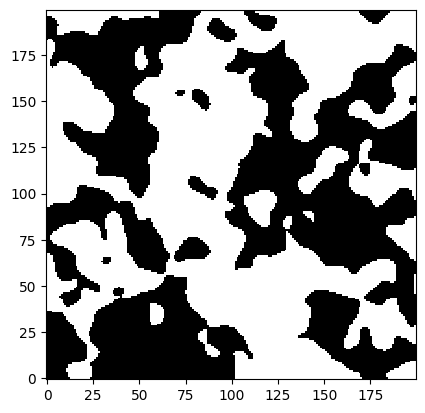

In [9]:
import numpy as np

def calc_proba_distance_shift(X, d_max):
    P, Q = X.shape
    Xf = X.ravel()
    N = P * Q

    # Precompute integer shifts up to d_max
    shifts = []
    for dx in range(-d_max+1, d_max):
        for dy in range(-d_max+1, d_max):
            dist = round(np.sqrt(dx*dx + dy*dy))
            if dist < d_max:
                shifts.append((dx, dy, dist))

    range_d = np.unique([s[2] for s in shifts])
    count_identical = np.zeros_like(range_d, dtype=float)

    for dx, dy, dist in shifts:
        # Overlapping regions after shifting
        x1 = max(0, dx); x2 = P + min(0, dx)
        y1 = max(0, dy); y2 = Q + min(0, dy)

        A = X[x1:x2, y1:y2]
        B = X[x1-dx:x2-dx, y1-dy:y2-dy]

        matches = (A == B).sum()
        total   = A.size

        i = np.where(range_d == dist)[0][0]
        count_identical[i] += matches / total

    count_identical /= N
    return count_identical, range_d


In [16]:
def proba_same_value_vs_distance_fft(X, d_max, include_zero=True):
    """
    Fast estimator of P[X(x) = X(x+h)] as a function of (rounded) distance ||h||,
    using linear autocorrelation of indicator images via FFT.

    Parameters
    ----------
    X : 2D ndarray (categorical/discrete values)
    d_max : int
        Max (rounded) distance to report. Distances are rounded to nearest integer.
    include_zero : bool
        Whether to include distance 0 (trivially 1.0).

    Returns
    -------
    p_same : 1D ndarray
        Probability of same value for each distance in `range_d`.
    range_d : 1D ndarray (int)
        The corresponding (rounded) distances.
    """
    X = np.asarray(X)
    P, Q = X.shape
    H, W = 2*P - 1, 2*Q - 1   # sizes for linear correlation via zero-padding

    # Map labels to compact 0..K-1 ints
    vals, Xc = np.unique(X, return_inverse=True)
    K = vals.size
    Xc = Xc.reshape(P, Q)

    # Build distance map for shifts (dx,dy) in the linear correlation grid
    # Shift (0,0) is at index (P-1, Q-1)
    yy, xx = np.ogrid[:H, :W]
    dx = (yy - (P - 1)).astype(np.int64)
    dy = (xx - (Q - 1)).astype(np.int64)
    dist_rounded = np.rint(np.sqrt(dx*dx + dy*dy)).astype(np.int64)

    # Mask shifts we will use
    use = dist_rounded < d_max
    if not include_zero:
        use &= ~((dx == 0) & (dy == 0))

    # Denominator: number of overlapping pairs for each shift (linear correlation of ones)
    ones = np.ones((P, Q), dtype=float)
    F1 = np.fft.fft2(ones, s=(H, W))
    denom = np.fft.ifft2(F1 * np.conj(F1)).real  # linear (not circular) pair counts

    # Numerator: sum over classes of "both ends in class c" pair counts at each shift
    num_total = np.zeros((H, W), dtype=float)
    for c in range(K):
        Ic = (Xc == c).astype(float)
        F = np.fft.fft2(Ic, s=(H, W))
        ac = np.fft.ifft2(F * np.conj(F)).real   # linear autocorrelation for class c
        num_total += ac

    # Aggregate over all shifts with the same rounded distance (weight by pair counts)
    d_vals = np.unique(dist_rounded[use])
    # Ensure distances are consecutive small integers for bincount indexing
    d_max_idx = d_vals.max()
    num_bins = d_max_idx + 1

    num_by_d = np.bincount(dist_rounded[use].ravel(),
                           weights=num_total[use].ravel(),
                           minlength=num_bins)
    den_by_d = np.bincount(dist_rounded[use].ravel(),
                           weights=denom[use].ravel(),
                           minlength=num_bins)

    # Keep only the distances we actually used
    num_by_d = num_by_d[d_vals]
    den_by_d = den_by_d[d_vals]

    # Probability at each distance = (equal pairs) / (all pairs)
    with np.errstate(divide='ignore', invalid='ignore'):
        p_same = np.where(den_by_d > 0, num_by_d / den_by_d, np.nan)

    return p_same, d_vals

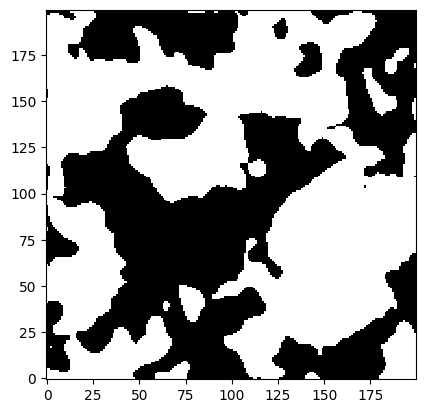

In [26]:
from mrfx.models import GUM
from mrfx.samplers import GUMSampler

kappa=0.1
gum = GUM(kappa=kappa, K=2, dim=2)
gum_sampler = GUMSampler(n_bands=2500, lx=200, ly=200, method="spectral")
key, subkey = jax.random.split(key, 2)
gum_x = gum_sampler.sample_image(gum, subkey)[0]
plt.imshow(gum_x)
plt.show()

In [27]:
import scipy.spatial as spa

count_identical,range_d = proba_same_value_vs_distance_fft(gum_x,d_max=20)

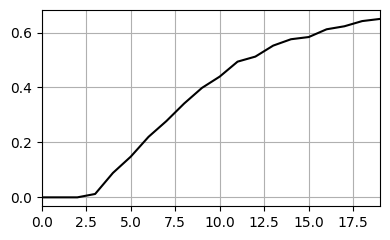

In [28]:
plt.figure(figsize=(4,2.5))
plt.plot(range_d,count_identical,'k')
plt.xlim(range_d[0],range_d[-1]);
plt.grid()
#plt.ylim(0.5,1)
plt.tight_layout()

In [12]:
count_identical

array([2.50000000e-05, 1.89970732e-04, 2.73271513e-04, 3.50318646e-04,
       6.69328928e-04, 5.59336853e-04, 7.68869162e-04, 7.40136957e-04,
       8.58172512e-04, 1.17332859e-03, 9.34709167e-04, 1.17262297e-03,
       1.08001213e-03, 1.36963892e-03, 1.34205008e-03, 1.25869932e-03,
       1.65419788e-03, 1.62959652e-03, 1.60821285e-03, 1.64631786e-03])